-----
# 02 - Unibiomarker Analysis

-----
# 02 - Unibiomarker Analysis

In [1]:
from pathlib import Path
import seaborn as sns
import pandas as pd

from utils import format_dataframe, add_ratio_columns
from unibiomarker import Unibiomarker
import constants

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Default Plot Style : 
sns.set(style="whitegrid")


## 1. Data Loading & Preparation

In [2]:
# Set path to Data Directory : 
DIR_DATA = Path.cwd() / "data"

# Check existence to training/test files : 
print(fr"Data Directory    : {str(DIR_DATA)}")
print(fr"Train Data exists : {(DIR_DATA / 'cercare_training_data.xlsx').exists()}")
print(fr"Test Data exists  : {(DIR_DATA / 'cercare_test_data.xlsx').exists()}")


Data Directory    : C:\Users\maichi\work\my_projects\CercareStatAnalysis\data
Train Data exists : True
Test Data exists  : True


In [3]:
# Load Cercare Training / Test Excel spreadsheets :
df_data = pd.read_excel(DIR_DATA / "cercare_training_data.xlsx").rename(columns=constants.DICT_RENAMING_MAPPING)
df_test = pd.read_excel(DIR_DATA / "cercare_test_data.xlsx").rename(columns=constants.DICT_RENAMING_MAPPING)

# Format dataframes : 
df_data = format_dataframe(df=df_data)
df_test = format_dataframe(df=df_test)

# Add the ratio columns : 
add_ratio_columns(df_data)
add_ratio_columns(df_test)

print("Data Loaded and formatted Successfully ! ")


Data Loaded and formatted Successfully ! 


##  2. 🔧  Configuration 

In [4]:
BIOMARKER = "COV"  # Choose from :  ADC, CBV_corr, CBV_noncorr, DELAY, CTH, CTH MAX, OEF, rLEAKAGE, rCMRO2, COV

In [5]:
# Unibiomarker object Initialization : 
ub = Unibiomarker(name=BIOMARKER, data = df_data, test_data=df_test)
print(ub)


Biomarker object
- Parameters: COV_lésion, COV_control, COV_ratio
- Training samples: 182
- Test samples: 23



## 3. Descriptive Analysis

### 3.1 Check for missing values

Fully usable rows in train: 179/182 (98.4%)
Fully usable rows in test:  23/23 (100.0%)


,Train Missing %,Test Missing %
COV_lésion,1.1,0.0
COV_control,1.6,0.0
COV_ratio,1.6,0.0


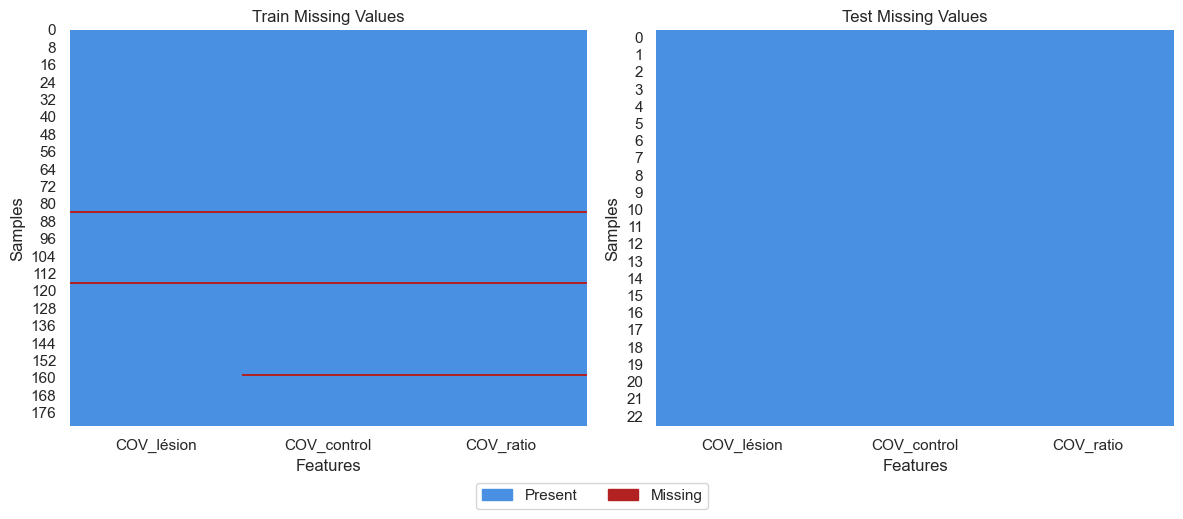

In [6]:
ub.check_missing_data()


### 3.2 Describe & Visualize key features

In [7]:
ub.describe_features(features=[ub.path, ub.control])


Overall Descriptive Statistics : 


,count,mean,std,min,25%,50%,75%,max
COV_lésion,180.0,1.462000,1.247696,0.03,0.520,1.14,2.050,9.64
COV_control,179.0,1.612626,0.913584,0.03,1.025,1.56,2.035,4.20



Descriptive Statistics by 'Diagnosis' Class:


,Feature,Class,count,mean,std,min,25%,50%,75%,max
0,COV_lésion,0,110.0,0.808727,0.963772,0.03,0.320,0.715,1.1075,9.64
2,COV_lésion,1,70.0,2.488571,0.906484,0.65,1.705,2.505,3.1500,4.94
1,COV_control,0,109.0,2.100275,0.776006,0.73,1.570,1.890,2.5900,4.20
3,COV_control,1,70.0,0.853286,0.499953,0.03,0.480,0.930,1.1600,2.21


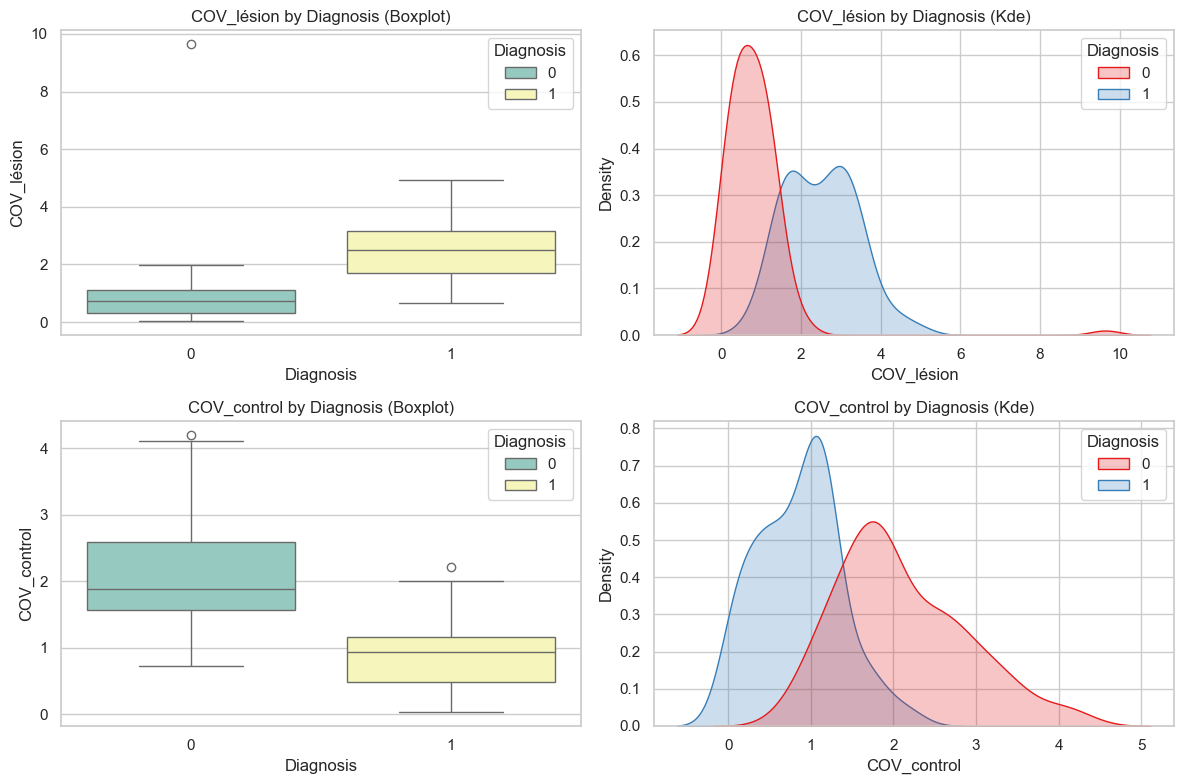

In [8]:
ub.plot_feature_distributions(features=[ub.path, ub.control], plots=["boxplot", "kde"])


### 3.3 Ratio Analysis

The goal of this section is to check correlation between the path variable and the control variable

The ratio is defined as:  
**`Ratio = Path / Control`**

To assess whether this ratio provides *new, meaningful information*, we first examine the correlation between `Path` and `Control` values:

---

#### 🔍 What we check

1. **Pearson correlation** (linear relationship)  
   Measures the strength of a **linear** association between `Path` and `Control`.

   $$
   r = \frac{\text{Cov}(X, Y)}{\sigma_X \cdot \sigma_Y}
   $$

2. **Spearman correlation** (monotonic relationship)  
   Applies the Pearson formula to the **ranked values** rather than raw values.

   $$
   \rho = \frac{\text{Cov}(\text{Rank}(X), \text{Rank}(Y))}{\sigma_{\text{Rank}(X)} \cdot \sigma_{\text{Rank}(Y)}}
   $$

   This makes Spearman suitable for detecting **monotonic relationships** that are not necessarily linear.

3. **Statistical significance** (p-values)  
   For both Pearson and Spearman, a **p-value** tests the null hypothesis that the correlation is zero (i.e., no association exists):

   - A **low p-value** (typically < 0.05) indicates that the correlation is **statistically significant**  
   - A **high p-value** means there is **insufficient evidence** to conclude that a statistically significant correlation exists
     

In [9]:
ub.describe_features(features=[ub.ratio])

Overall Descriptive Statistics : 


,count,mean,std,min,25%,50%,75%,max
COV_ratio,179.0,2.308281,5.548601,0.019108,0.302016,0.48062,2.67004,51.666667



Descriptive Statistics by 'Diagnosis' Class:


,Feature,Class,count,mean,std,min,25%,50%,75%,max
0,COV_ratio,0,109.0,0.361655,0.357406,0.019108,0.216216,0.337278,0.437186,3.693487
1,COV_ratio,1,70.0,5.339456,7.994641,1.632653,2.452781,2.971311,3.810774,51.666667


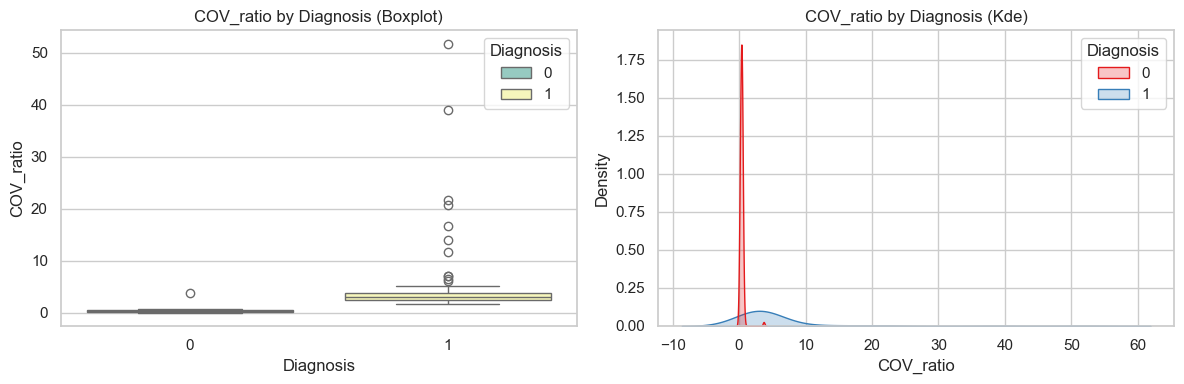

In [10]:
ub.plot_feature_distributions(features=[ub.ratio], plots=["boxplot", "kde"])

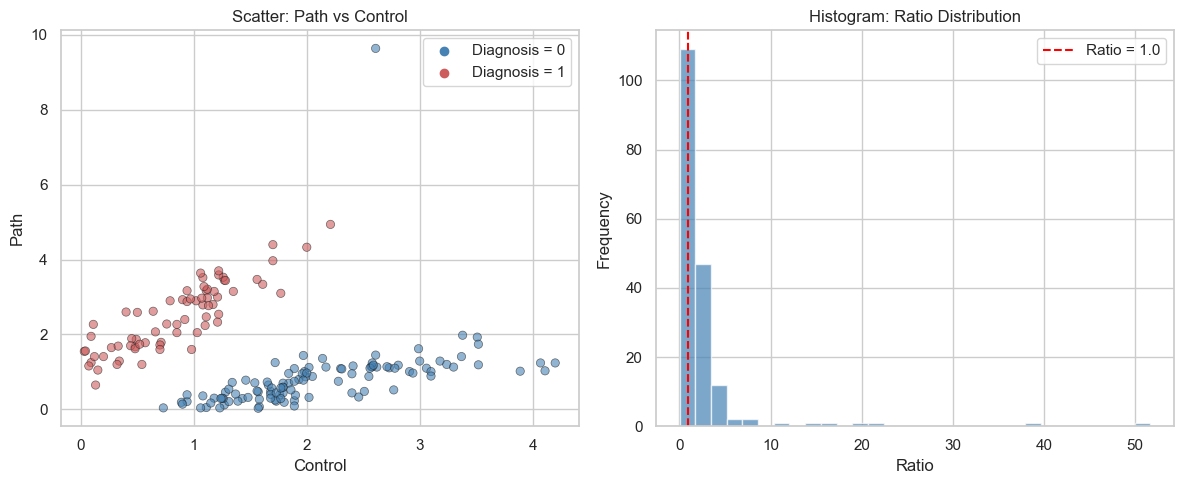

In [11]:
ub.plot_diagnostic_scatter_and_ratio()

In [12]:
ub.evaluate_path_control_correlation()

🔍 Analyzing Biomarker: COV
------------------------------------------------------------------------------------------------------------------------------------------------------
--- Step 1: Correlation Analysis between Path and Control 
------------------------------------------------------------------------------------------------------------------------------------------------------
- Pearson  correlation: r = -0.139, p = 0.0638
- Spearman correlation: r = -0.236, p = 0.0015

------------------------------------------------------------------------------------------------------------------------------------------------------
--- Step 2: Interpretation Guidance 
------------------------------------------------------------------------------------------------------------------------------------------------------
Spearman correlation is significant (p < 0.05), but Pearson is not ! 
This suggests a monotonic but non-linear relationship ! 
The ratio may still be useful in this case


## 4.  Discriminative Power of the Biomarker


In this section, we assess whether features like `path` and `ratio` can **discriminate between diagnostic groups**, such as Tumor Recurrence and Radiation Necrosis.

---

#### Step 1 – Normality Check

We start with **Q–Q plots** to visually evaluate whether the distribution of the feature within each group appears **approximately normal**. This helps decide whether we can meaningfully apply a parametric test that models the **data distribution**.

---
#### Step 2 – Choosing the Right Statistical Test

- If the feature appears **normally distributed** in each group, we apply a **Welch’s t-test**.
  - This test assumes the data follows a normal distribution and compares the **means** between groups.
  - Using a parametric test like this is valuable because it lets us **model the data with a known distribution**

- If the feature **does not appear normally distributed**, we instead use the **Mann–Whitney U test**.
  - This is a **non-parametric** test that compares whether values in one group tend to be higher or lower than in the other.
  - It doesn’t assume any specific distribution and works on **ranked data** rather than actual values.
  - But it doesn’t let us **model or describe the underlying distribution** of the data 

---

#### Step 3 – Interpreting the Results

If either test reports a **statistically significant difference** (typically p < 0.05), it suggests that the feature behaves differently between groups — a necessary condition for it to be useful as a biomarker

### 4.1. Distribution Differences: Path Feature

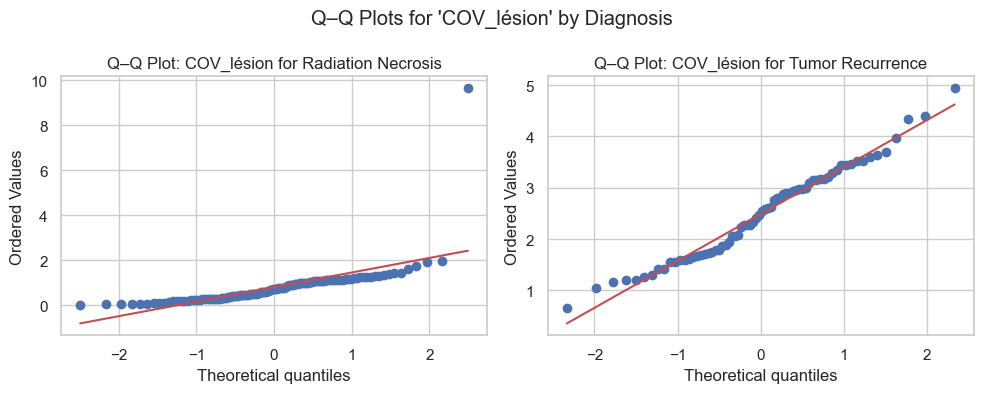

In [13]:
ub.plot_qq_by_group(feature=ub.path)

In [14]:
ub.test_group_difference(feature=ub.path)

Group Comparison Results:
----------------------------------------------------------------------------------------------------
Welch’s t-test       → statistic = -11.8243, p = 0.0000   → ✅ Significant difference
Mann–Whitney U test  → statistic = 286.5000, p = 0.0000   → ✅ Significant difference



🔎 [ROC-Based Classification] Feature: 'COV_lésion'
--------------------------------------------------------------------------------
AUC (Train) : 0.963  (95% CI: 0.935 – 0.990)
AUC (Test)  : 0.607  (95% CI: 0.300 – 0.914)

 Optimal threshold (Youden’s J): 1.410
 Classification Rule          : Class = 1 if COV_lésion ≥ 1.410

▶ TRAIN SET METRICS AT THRESHOLD: 1.410
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      91.7
Recall (Sensitivity) |      90.0
Specificity          |      92.7
Precision            |      88.7
F1 Score             |      89.4

▶ TEST SET METRICS AT THRESHOLD: 1.410
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      60.9
Recall (Sensitivity) |      42.9
Specificity          |      68.8
Precision            |      37.5
F1 Score             | 

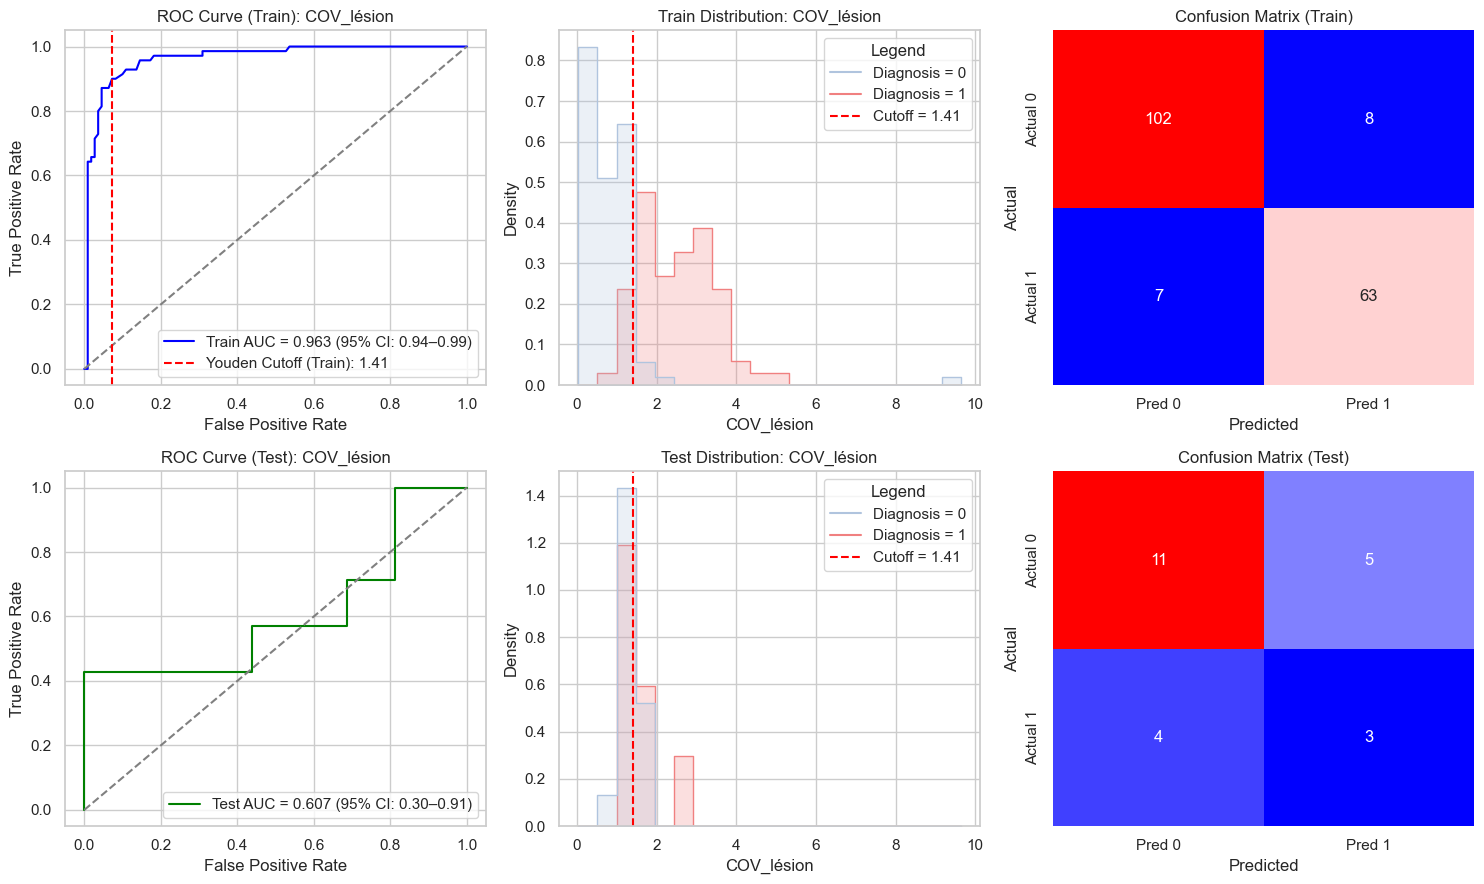

In [15]:
ub.evaluate_feature_predictive_power(feature=ub.path, target_bin_count=20)

### 4.2. Distribution Differences: Path Feature

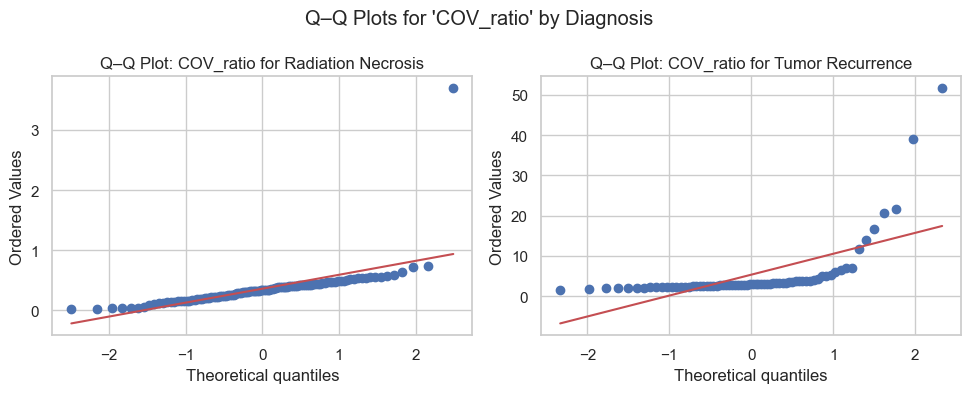

In [16]:
ub.plot_qq_by_group(feature=ub.ratio)

In [17]:
ub.test_group_difference(feature=ub.ratio)

Group Comparison Results:
----------------------------------------------------------------------------------------------------
Welch’s t-test       → statistic = -5.2061, p = 0.0000   → ✅ Significant difference
Mann–Whitney U test  → statistic = 50.0000, p = 0.0000   → ✅ Significant difference



🔎 [ROC-Based Classification] Feature: 'COV_ratio'
--------------------------------------------------------------------------------
AUC (Train) : 0.993  (95% CI: 0.981 – 1.000)
AUC (Test)  : 0.598  (95% CI: 0.297 – 0.900)

 Optimal threshold (Youden’s J): 1.633
 Classification Rule          : Class = 1 if COV_ratio ≥ 1.633

▶ TRAIN SET METRICS AT THRESHOLD: 1.633
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      99.4
Recall (Sensitivity) |     100.0
Specificity          |      99.1
Precision            |      98.6
F1 Score             |      99.3

▶ TEST SET METRICS AT THRESHOLD: 1.633
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      73.9
Recall (Sensitivity) |      28.6
Specificity          |      93.8
Precision            |      66.7
F1 Score             |   

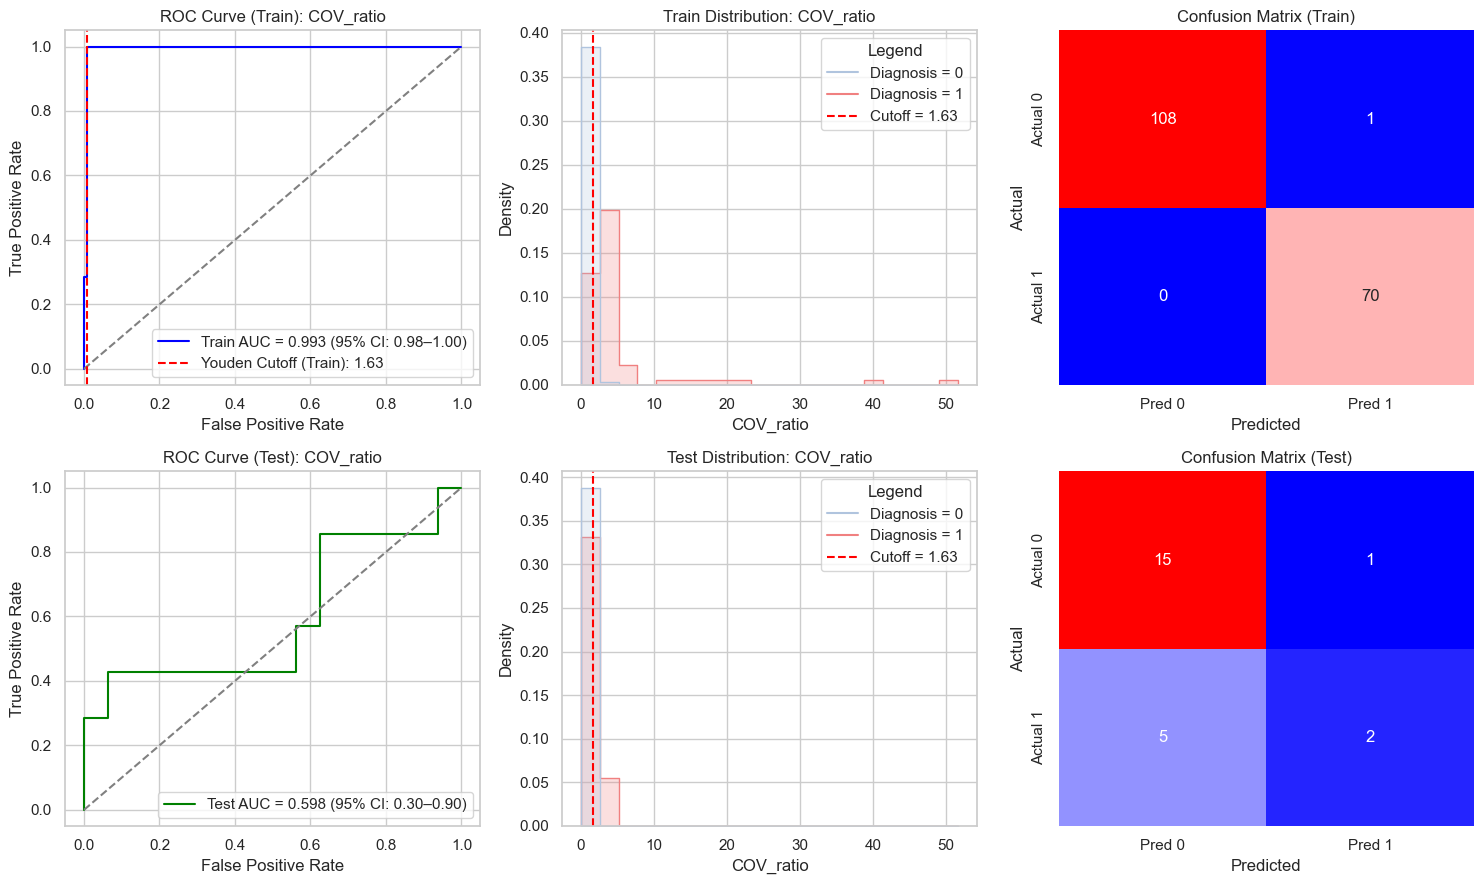

In [18]:
ub.evaluate_feature_predictive_power(feature=ub.ratio, target_bin_count=20)

## 5.  Logistic Regression Modelling

### 5.1 Univariate Logistic Regression 


Logistic Regression Summary for Feature: COV_lésion
----------------------------------------------------------------------------------------------------
Log-Odds Coefficient : 2.3903
Odds Ratio           : 10.9166
Youden's J Threshold : 0.3725
----------------------------------------------------------------------------------------------------

--- Inference Using statsmodels ---
Odds Ratio (statsmodels)  : 10.9165
95% CI for OR             : (5.3875, 22.1197)
p-value                   : 3.2672e-11
----------------------------------------------------------------------------------------------------

▶ [COV_LÉSION] TRAIN @ 0.5
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      90.0
Recall (Sensitivity) |      80.0
Specificity          |      96.4
Precision            |      93.3
F1 Score             |      86.2

▶ [COV_LÉSION] TRAIN @ YOUDEN
-----------------------------------

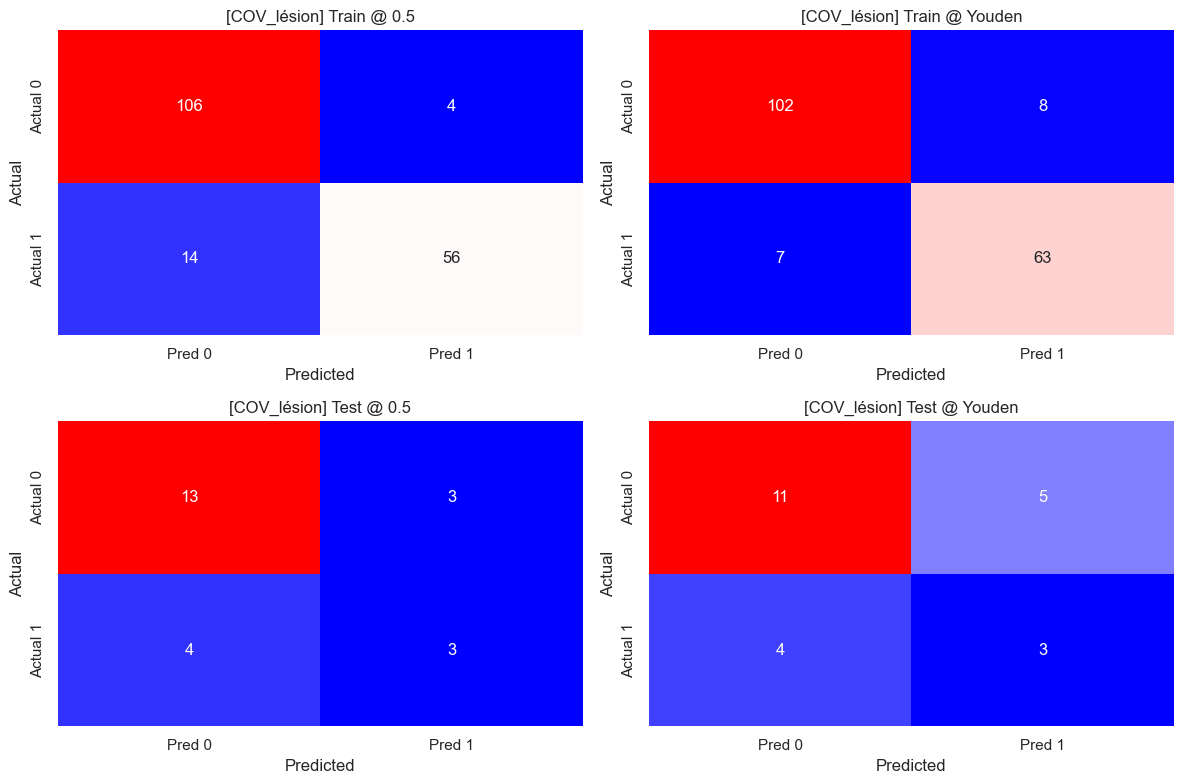

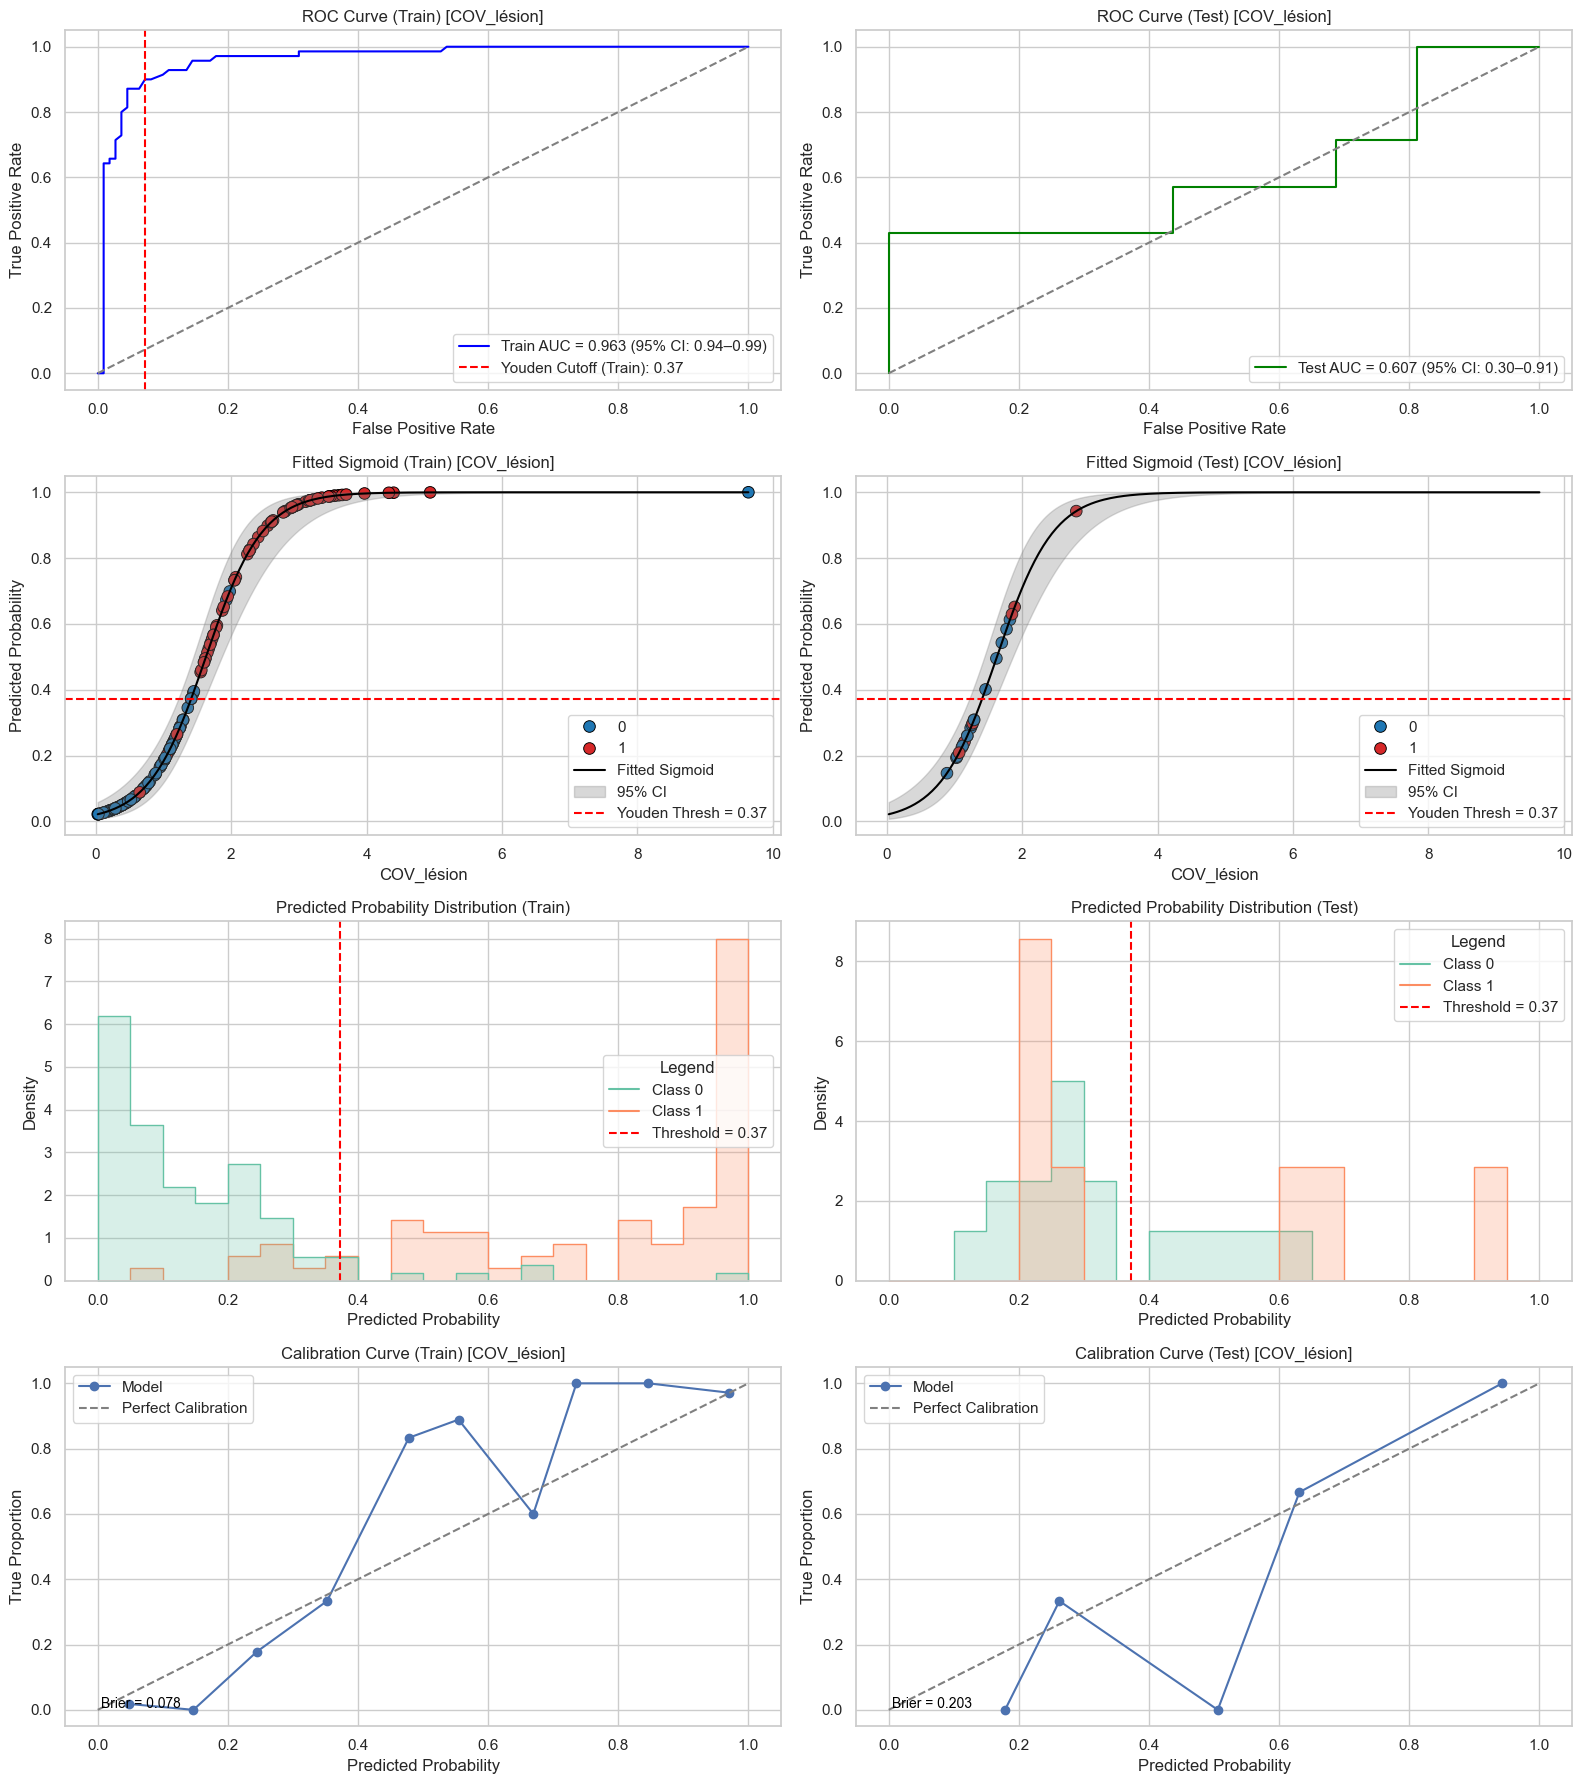

In [19]:
ub.evaluate_logistic_univariate_model(feature=ub.path, target_bin_count=20)


Logistic Regression Summary for Feature: COV_ratio
----------------------------------------------------------------------------------------------------
Log-Odds Coefficient : 4.0175
Odds Ratio           : 55.5638
Youden's J Threshold : 0.5996
----------------------------------------------------------------------------------------------------

--- Inference Using statsmodels ---
Odds Ratio (statsmodels)  : 55.5637
95% CI for OR             : (13.6188, 226.6961)
p-value                   : 2.1421e-08
----------------------------------------------------------------------------------------------------

▶ [COV_RATIO] TRAIN @ 0.5
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      99.4
Recall (Sensitivity) |     100.0
Specificity          |      99.1
Precision            |      98.6
F1 Score             |      99.3

▶ [COV_RATIO] TRAIN @ YOUDEN
------------------------------------

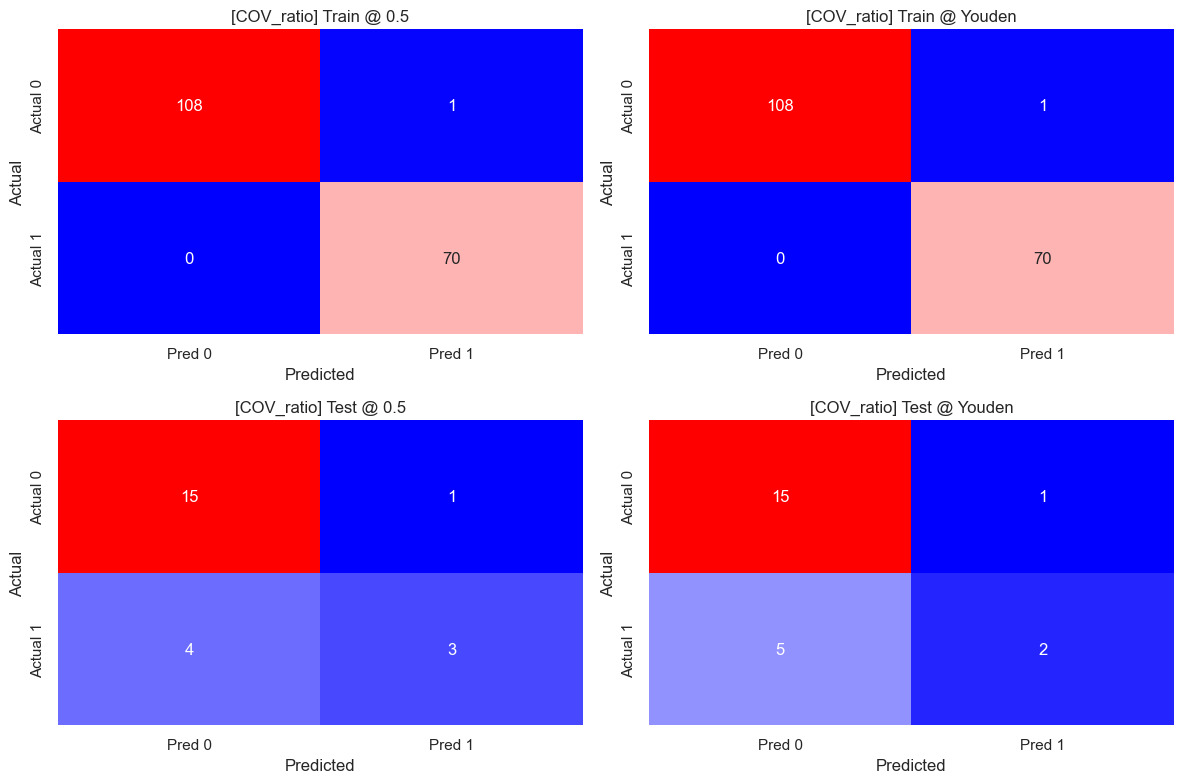

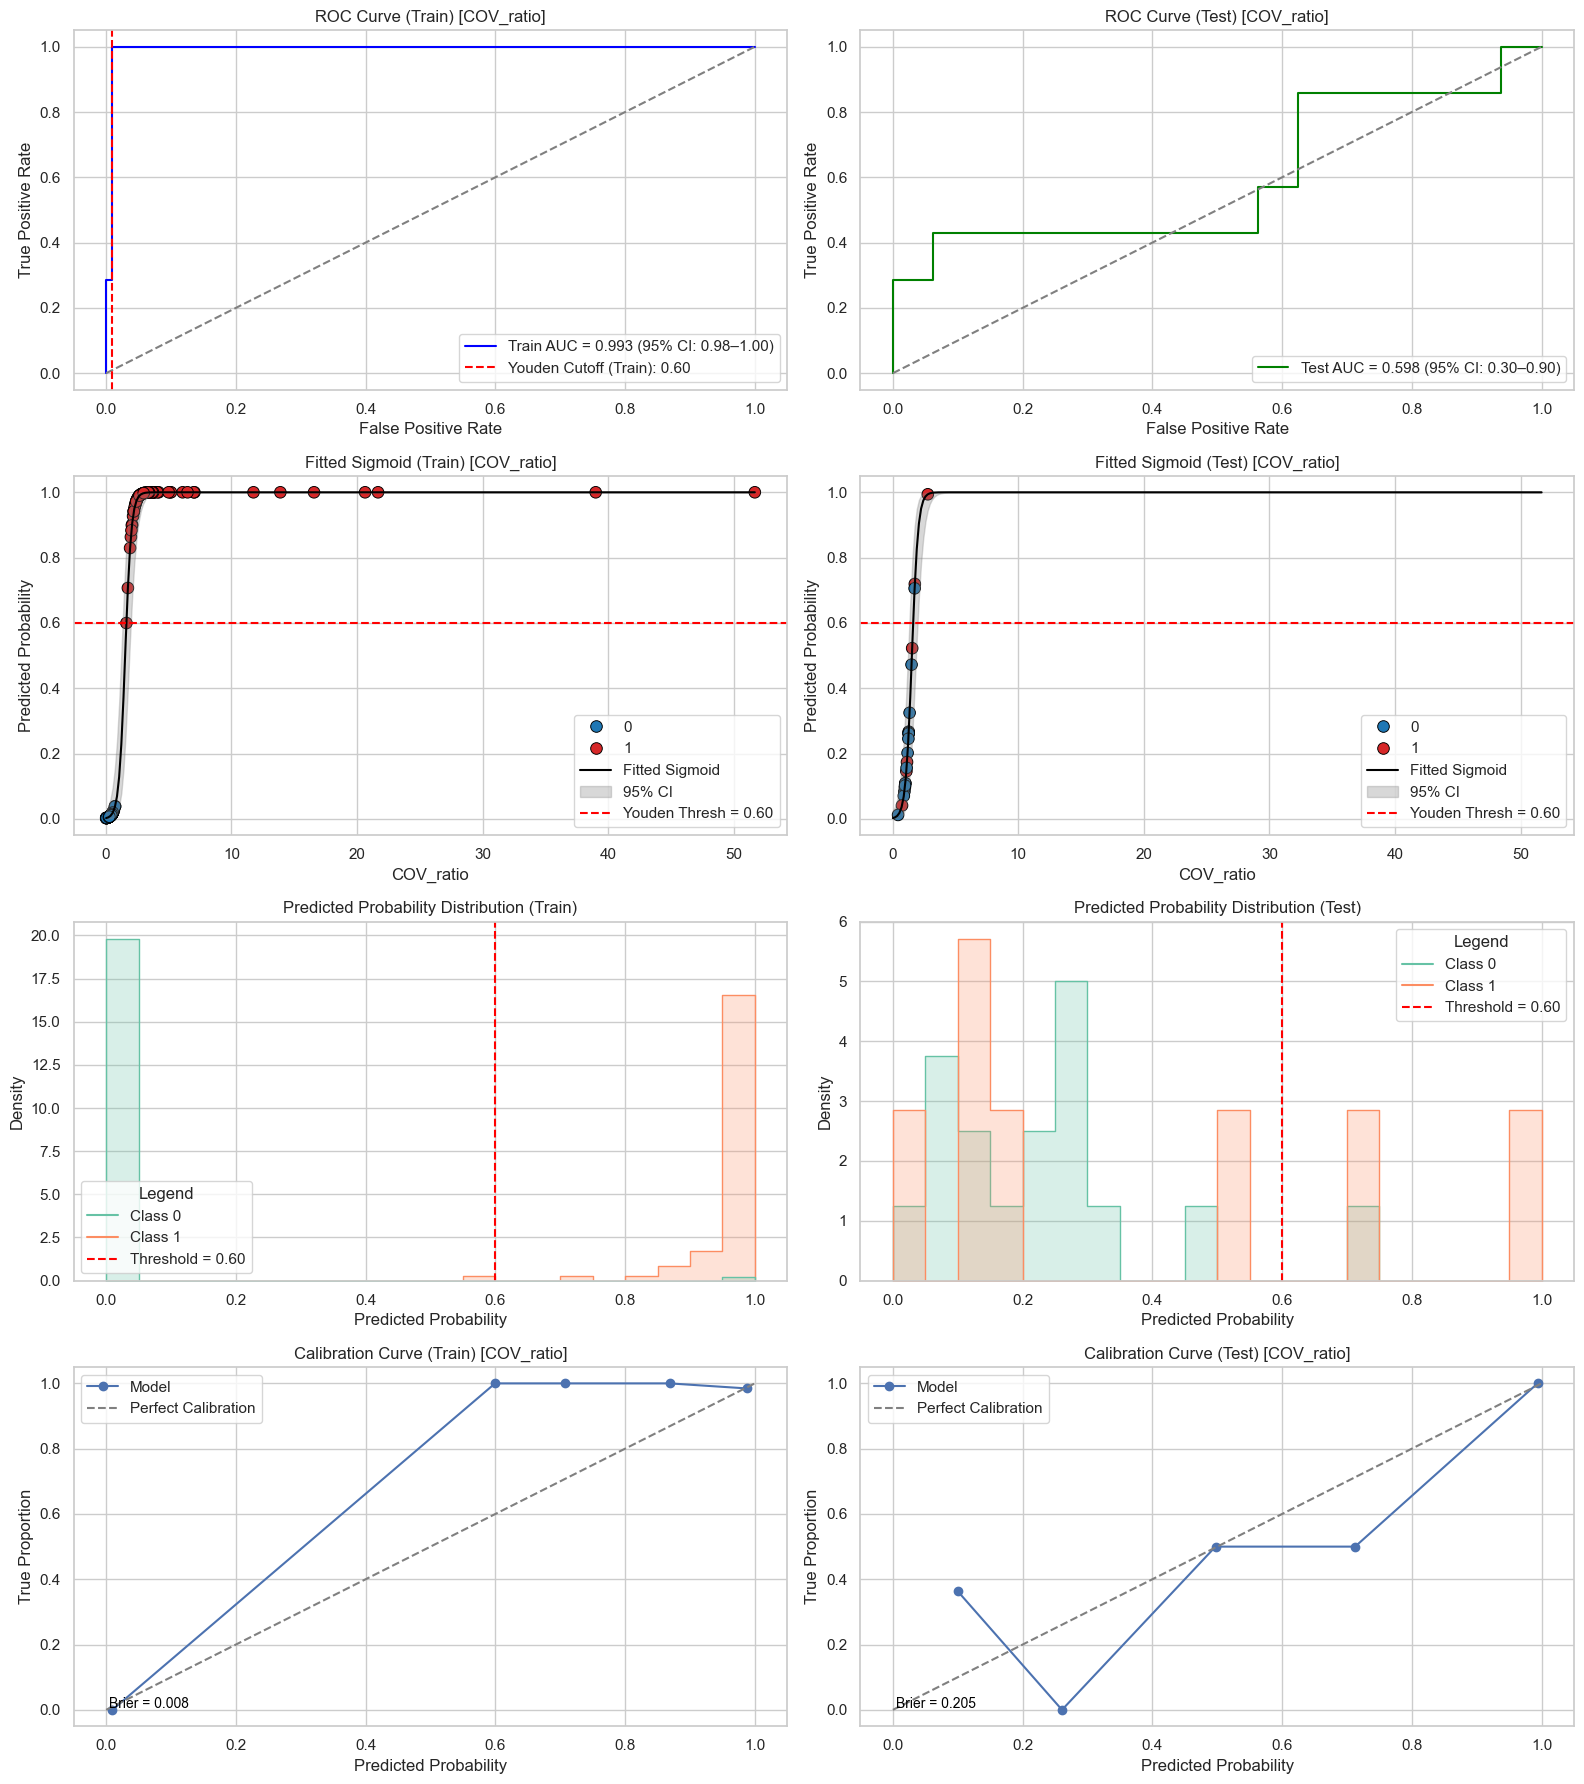

In [20]:
ub.evaluate_logistic_univariate_model(feature=ub.ratio,  target_bin_count=20)

### 5.2 Bivariate Logistic Regression 

BIVARIATE LOGISTIC REGRESSION: COV_lésion + COV_control
----------------------------------------------------------------------------------------------------
AUC (Train): 0.991 (95% CI: 0.973 – 1.000)
AUC (Test) : 0.598 (95% CI: 0.314 – 0.882)
Optimal Threshold (Youden’s J): 0.375

--- Inference Using statsmodels ---
Adjusted ORs per +1 SD (Training scale)
Odds Ratio (COV_lésion)     : 18.3496
95% CI for OR (COV_lésion)  : (5.8050, 58.0029)
p-value (COV_lésion)        : 7.2307e-07
Standard Deviation (COV_lésion) used for scaling: 1.24363
Odds Ratio (COV_control)     : 0.0015
95% CI for OR (COV_control)  : (0.0001, 0.0364)
p-value (COV_control)        : 6.0249e-05
Standard Deviation (COV_control) used for scaling: 0.911028

▶ [COV_LÉSION + COV_CONTROL] TRAIN @ 0.5
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      98.9
Recall (Sensitivity) |      98.6
Specificity          |   

C:\Users\maichi\work\my_projects\CercareStatAnalysis\unibiomarker.py:367: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef_sd = float(logit_model.params[idx])
C:\Users\maichi\work\my_projects\CercareStatAnalysis\unibiomarker.py:373: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pval     = float(pvals[idx])


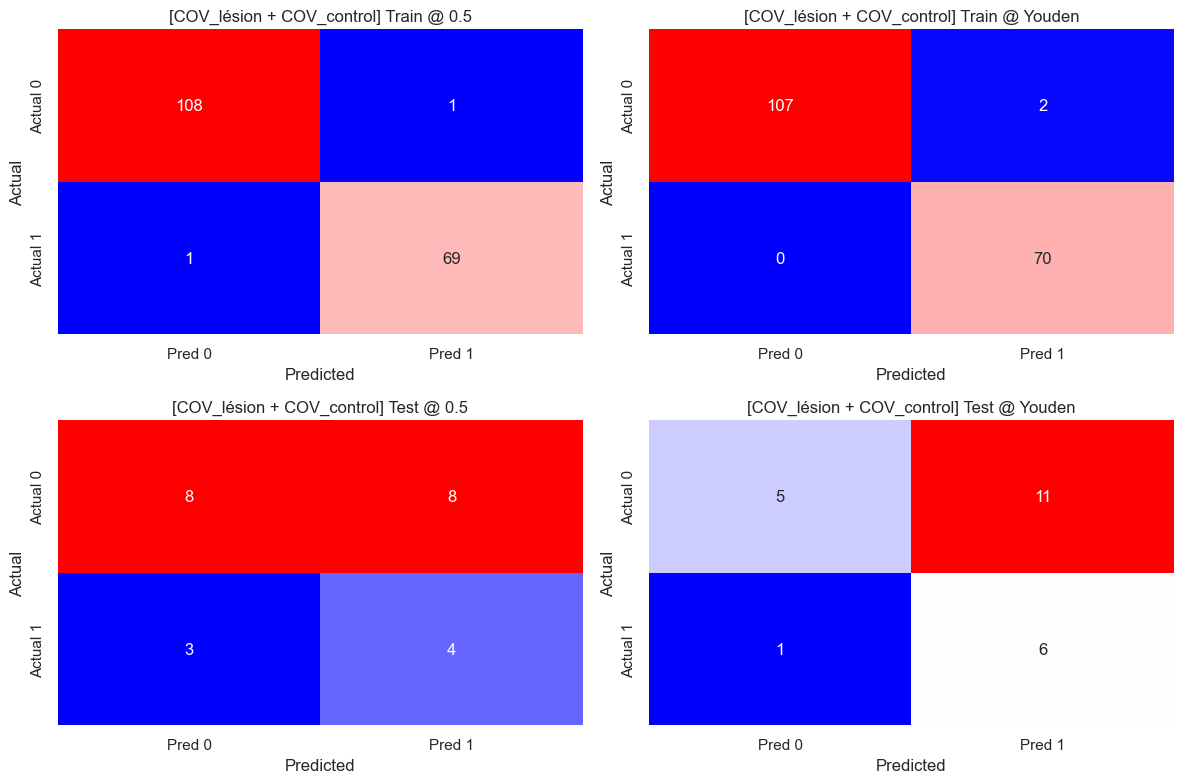

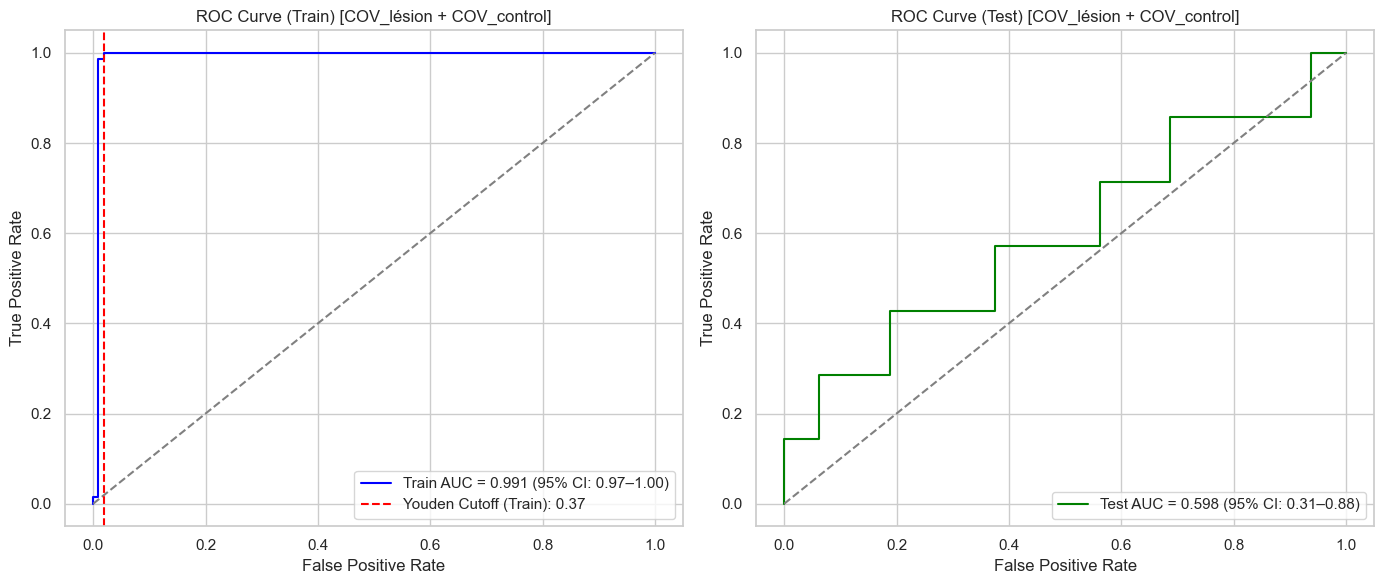

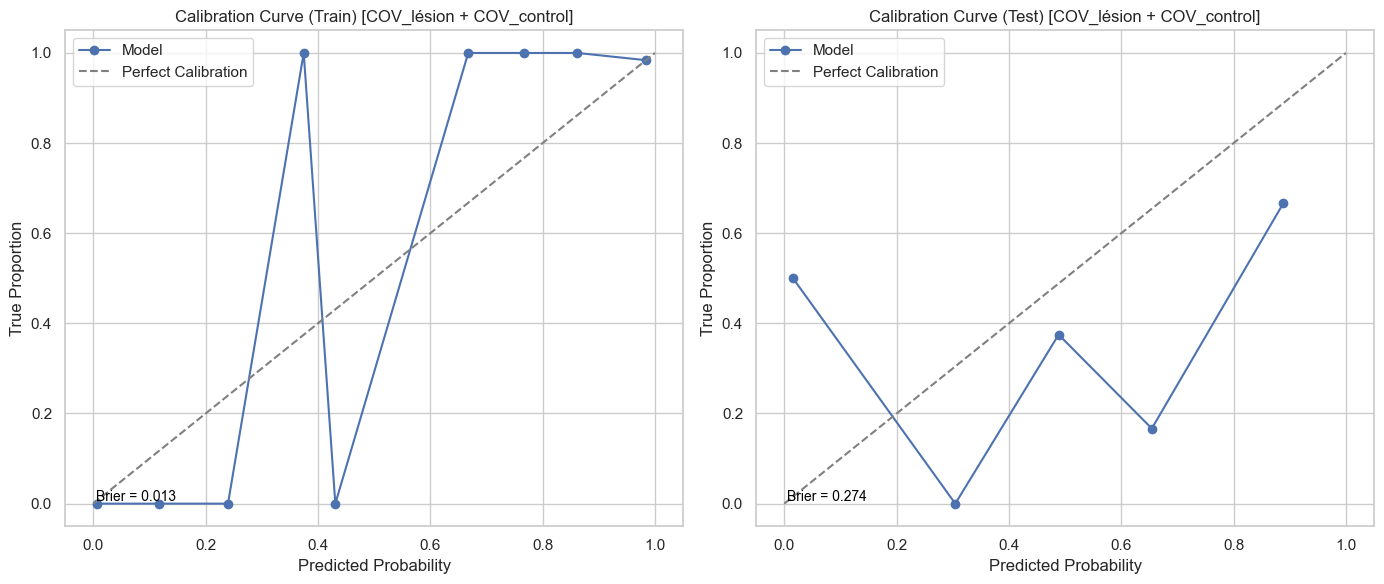

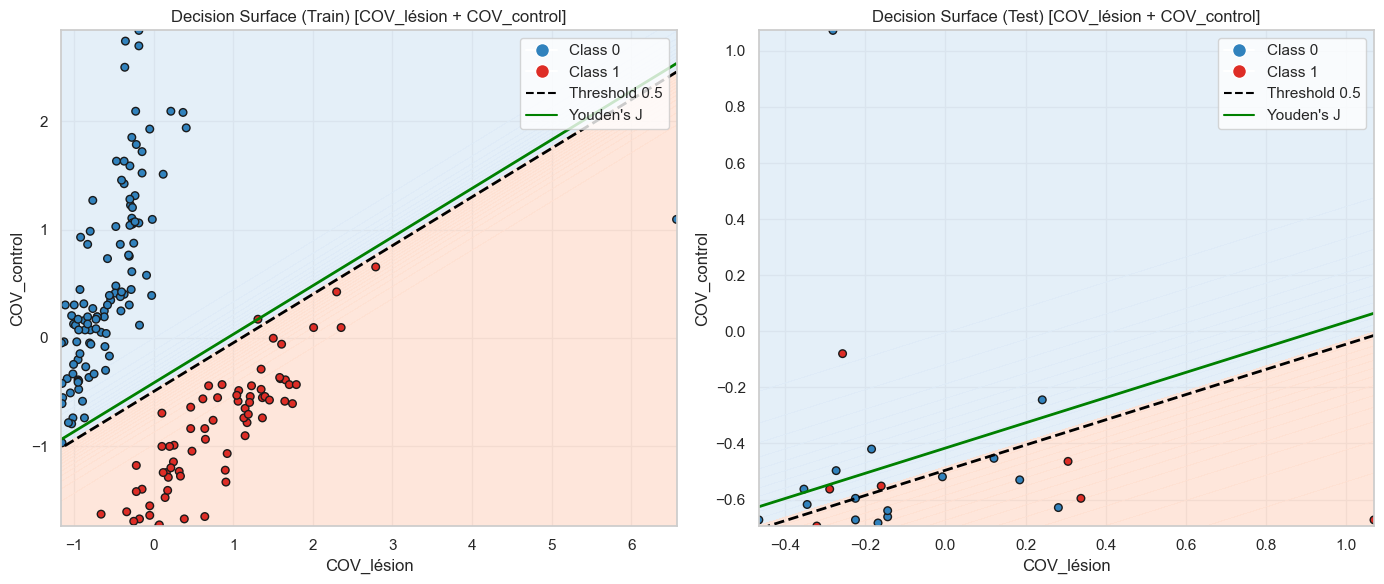

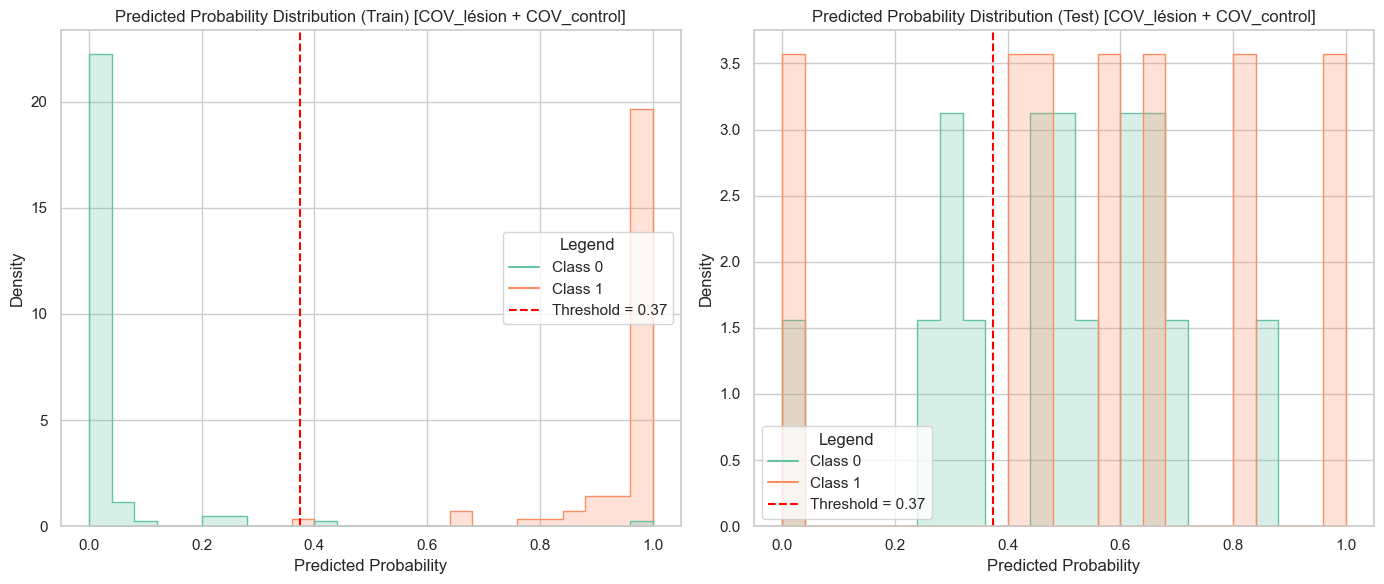

In [21]:
ub.evaluate_logistic_bivariate_model(target_bin_count=25)

## 5.  SVM Modelling

SVM (LINEAR) BIVARIATE: COV_lésion + COV_control
----------------------------------------------------------------------------------------------------
[Margin] Train AUC : 0.991 (95% CI: 0.973 – 1.000)
[Margin] Test  AUC : 0.598 (95% CI: 0.296 – 0.900)
Optimal Margin Cutoff (Youden): 0.515
----------------------------------------------------------------------------------------------------
[Proba]  Train AUC : 0.991 (95% CI: 0.973 – 1.000)
[Proba]  Test  AUC : 0.598 (95% CI: 0.296 – 0.900)
Optimal Proba  Cutoff (Youden): 0.657

▶ [COV_LÉSION + COV_CONTROL] TRAIN @ F(X) ≥ 0
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      99.4
Recall (Sensitivity) |     100.0
Specificity          |      99.1
Precision            |      98.6
F1 Score             |      99.3

▶ [COV_LÉSION + COV_CONTROL] TRAIN @ F(X) ≥ YOUDEN
--------------------------------------------------
Metric            

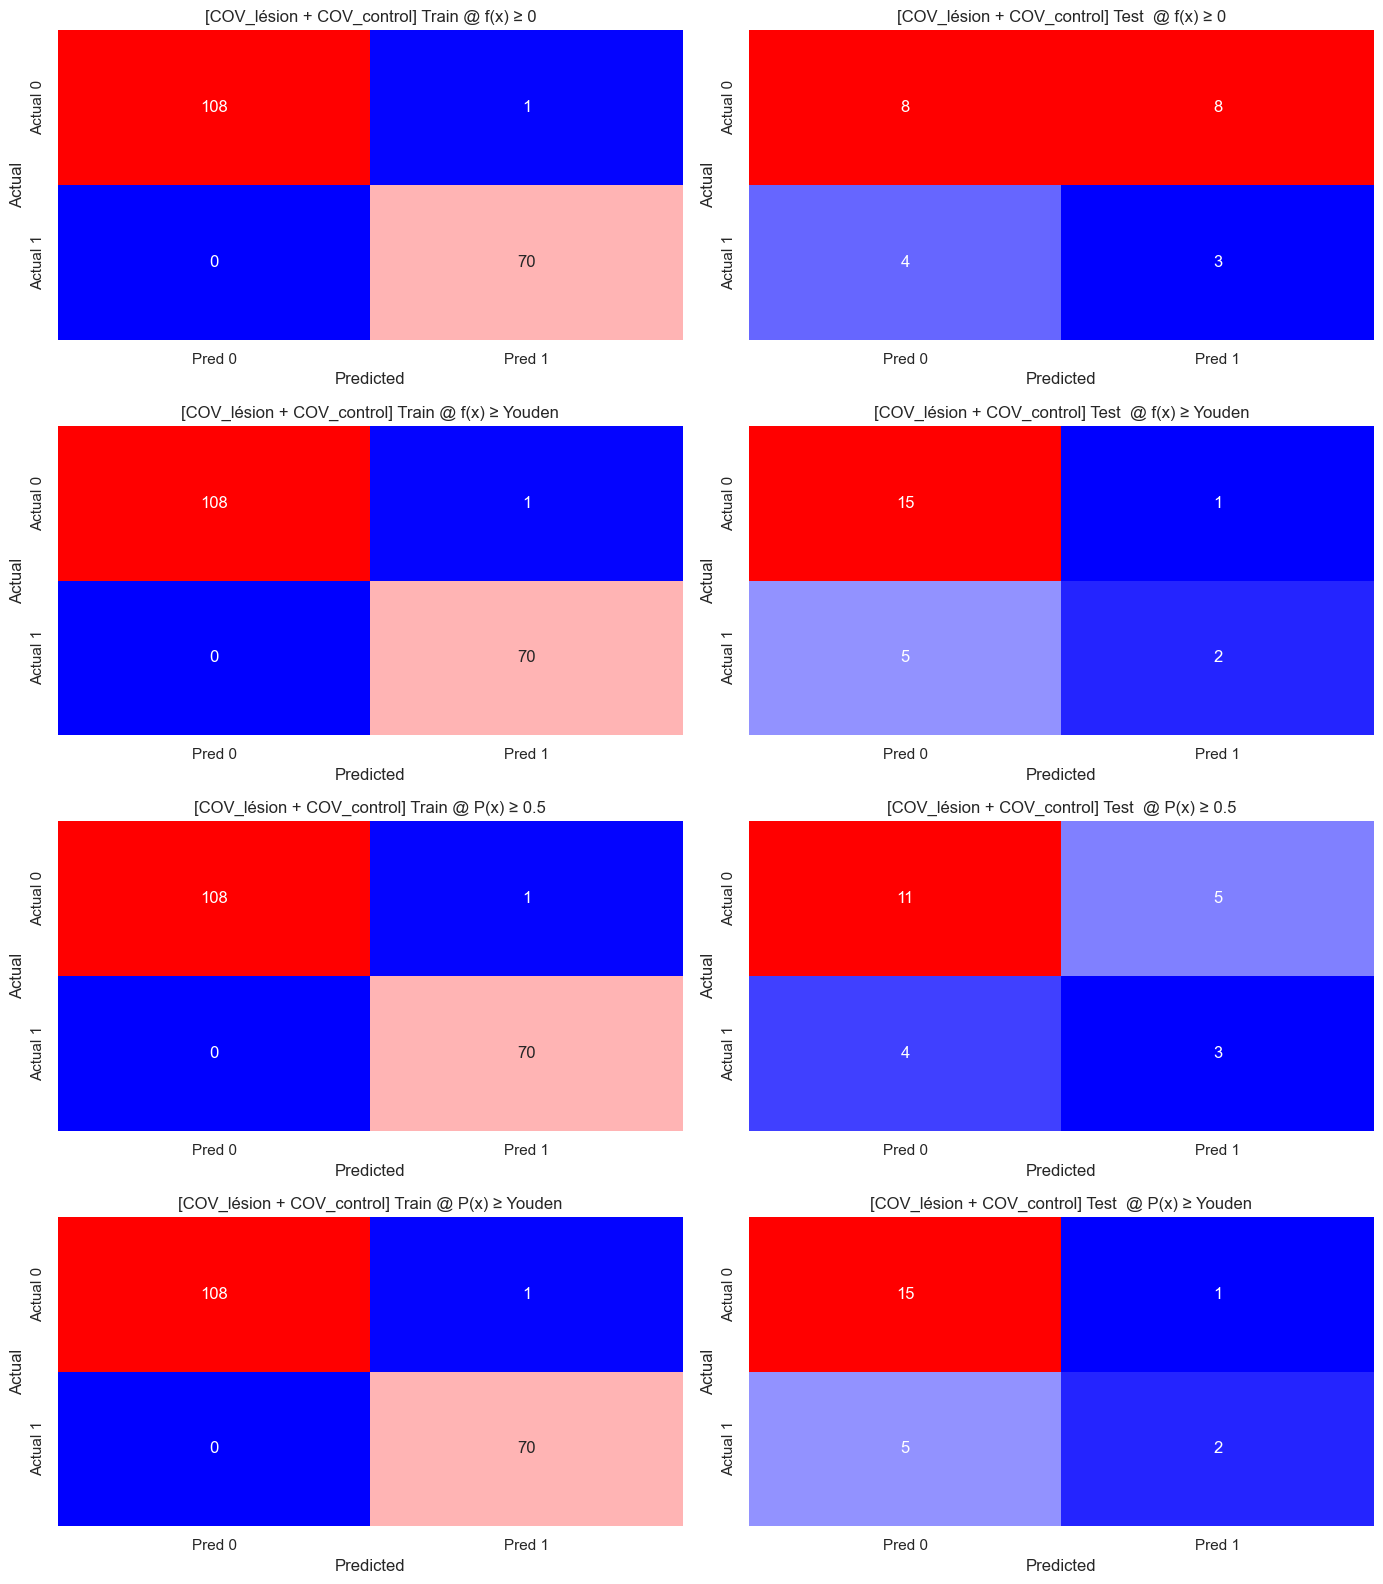

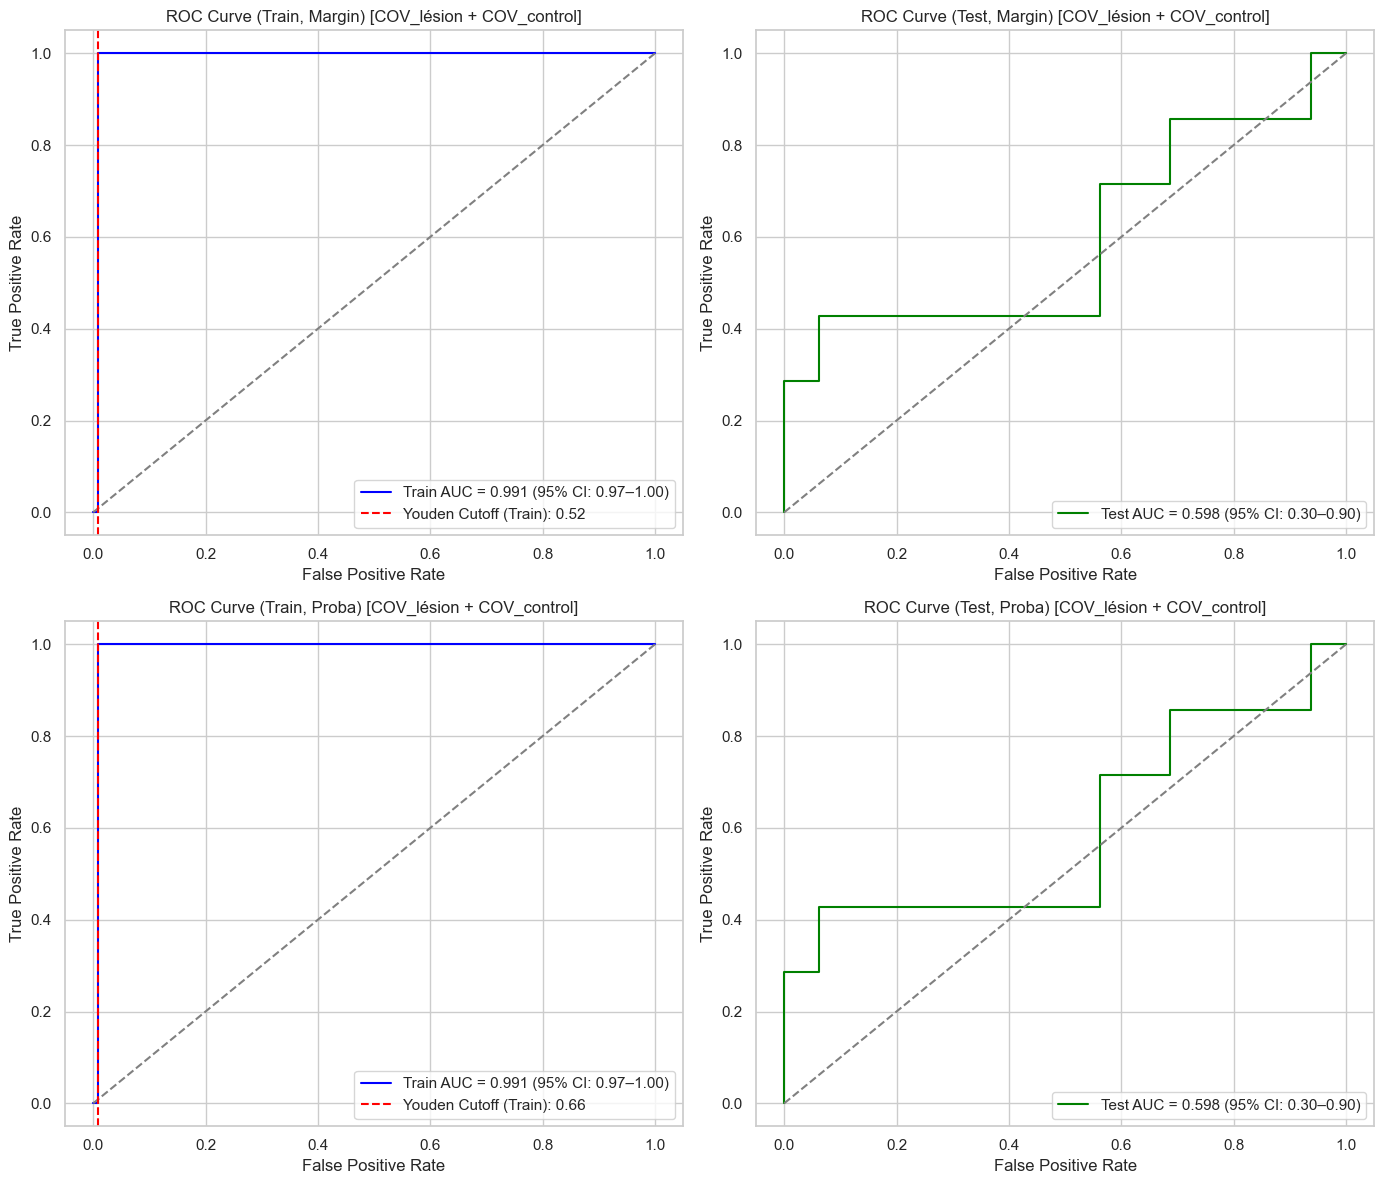

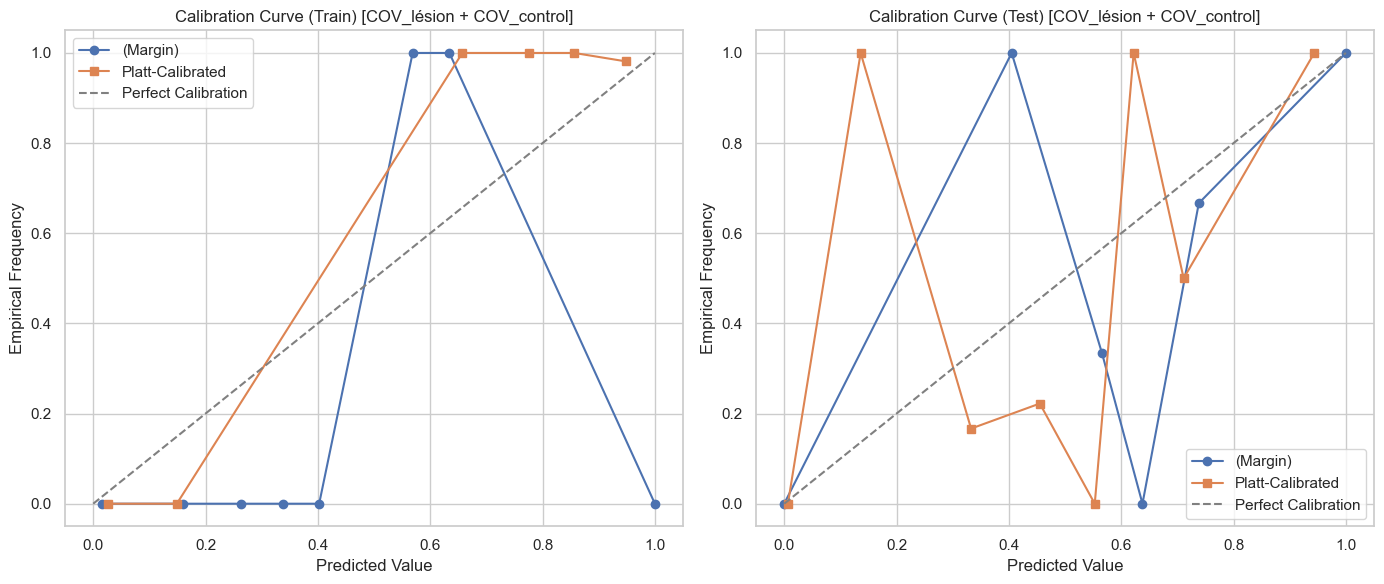

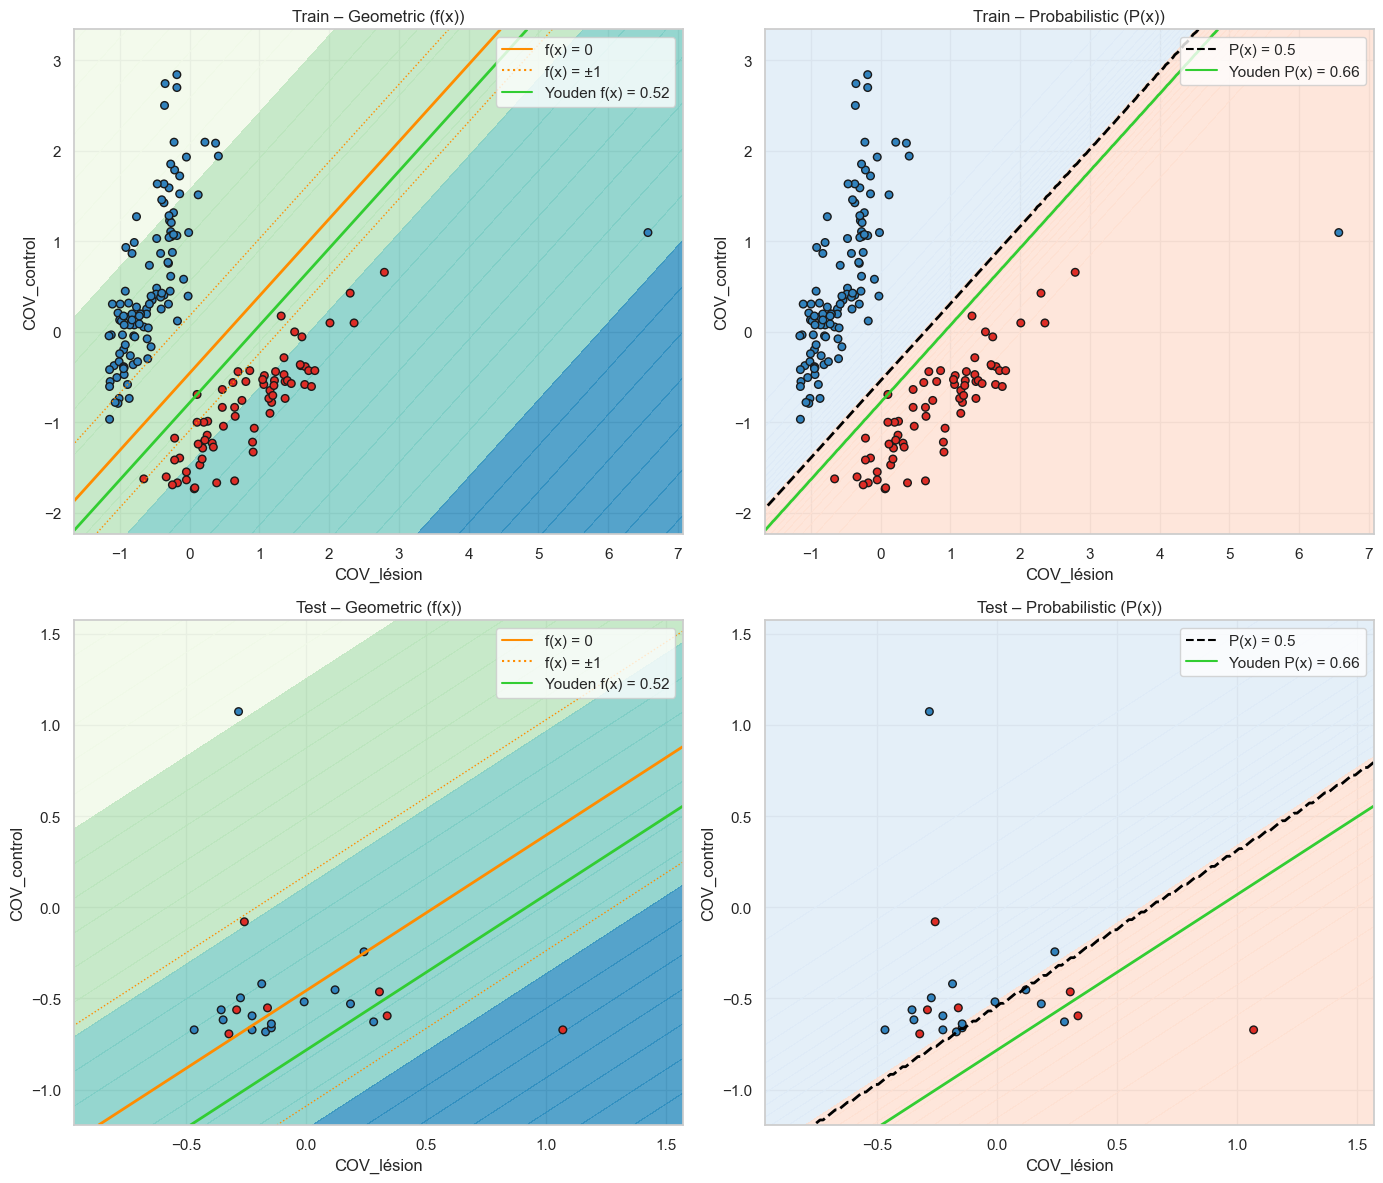

In [22]:
ub.evaluate_svm_bivariate_model(kernel="linear")

Covariance of AUC is 0.0; defaulting to a small delta for CI computation.
Covariance of AUC is 0.0; defaulting to a small delta for CI computation.
SVM (RBF) BIVARIATE: COV_lésion + COV_control
----------------------------------------------------------------------------------------------------
[Margin] Train AUC : 1.000 (95% CI: 1.000 – 1.000)
[Margin] Test  AUC : 0.598 (95% CI: 0.297 – 0.900)
Optimal Margin Cutoff (Youden): 0.601
----------------------------------------------------------------------------------------------------
[Proba]  Train AUC : 1.000 (95% CI: 1.000 – 1.000)
[Proba]  Test  AUC : 0.598 (95% CI: 0.297 – 0.900)
Optimal Proba  Cutoff (Youden): 0.893

▶ [COV_LÉSION + COV_CONTROL] TRAIN @ F(X) ≥ 0
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |     100.0
Recall (Sensitivity) |     100.0
Specificity          |     100.0
Precision            |     100.0
F1 Score 

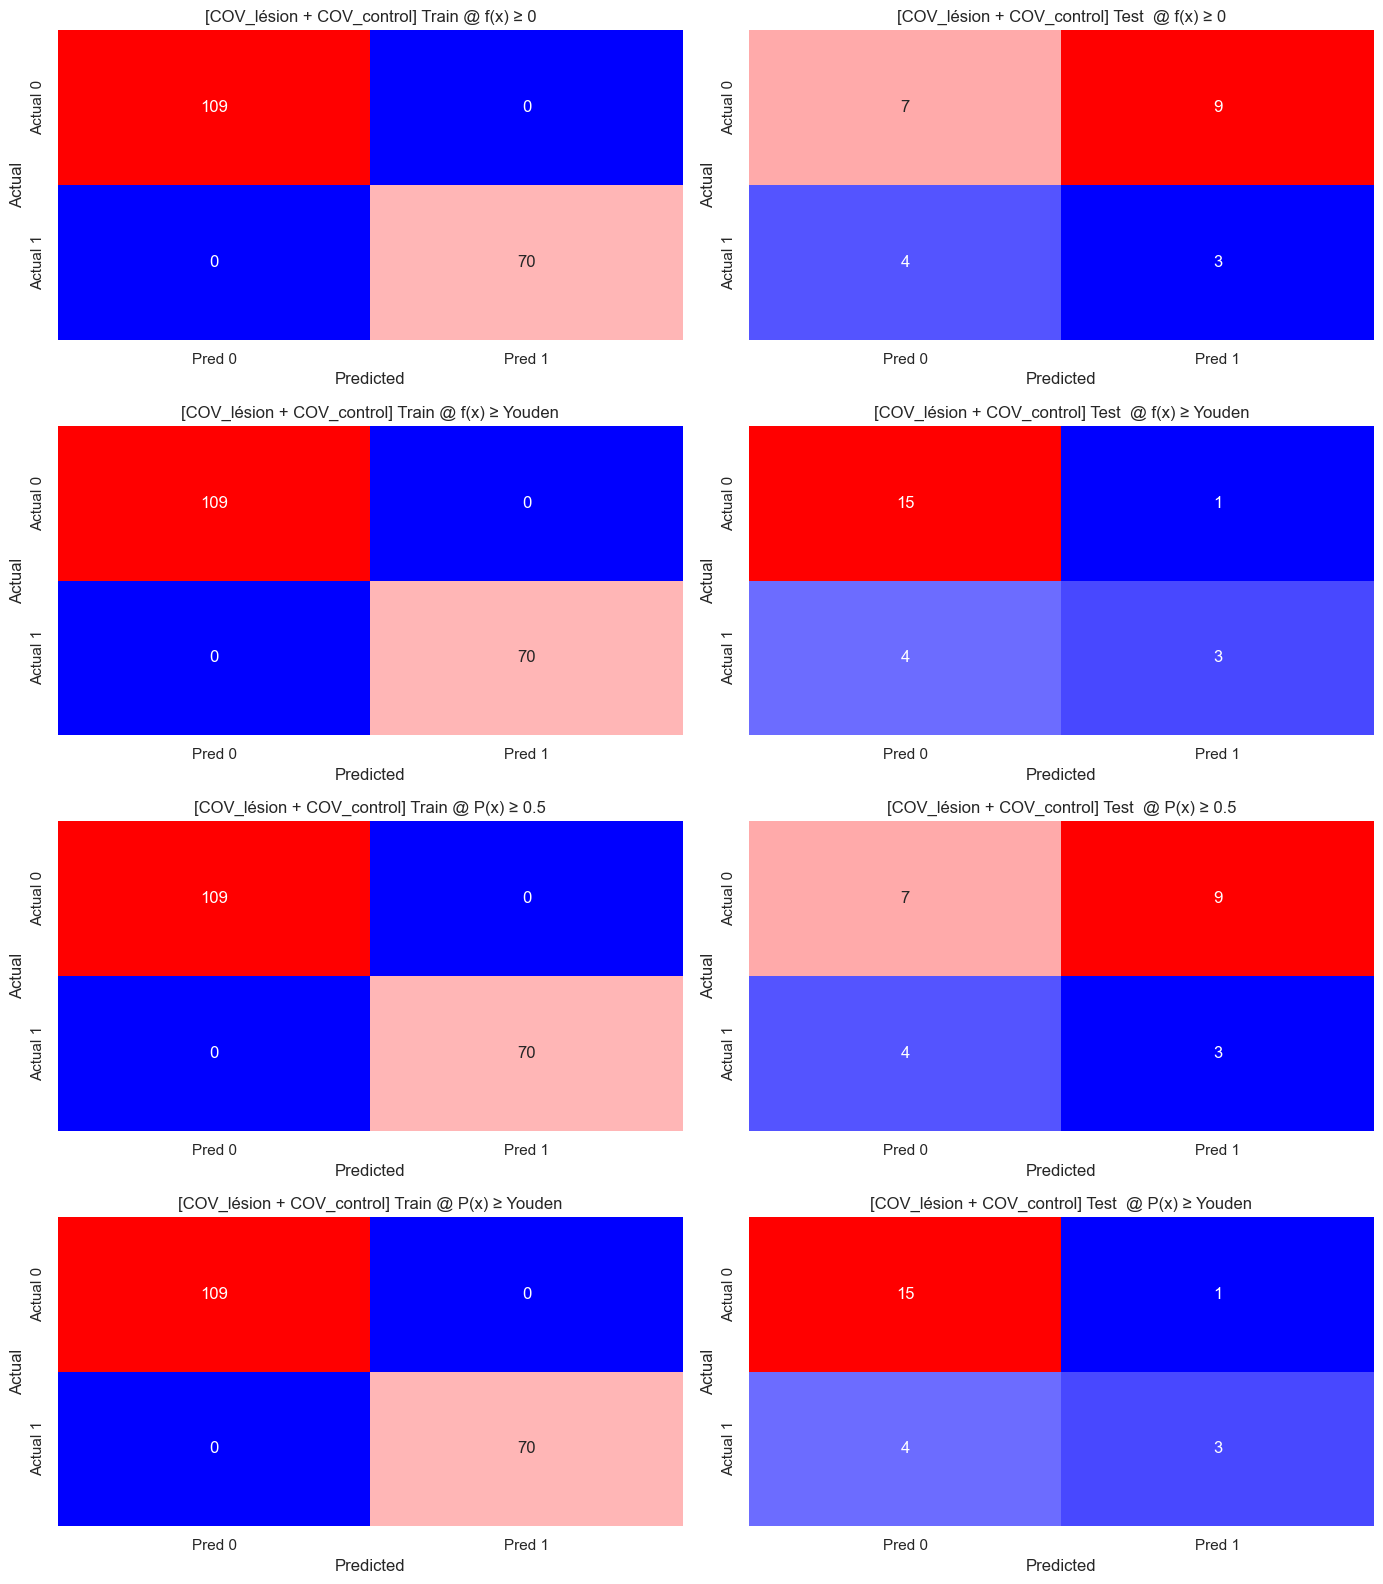

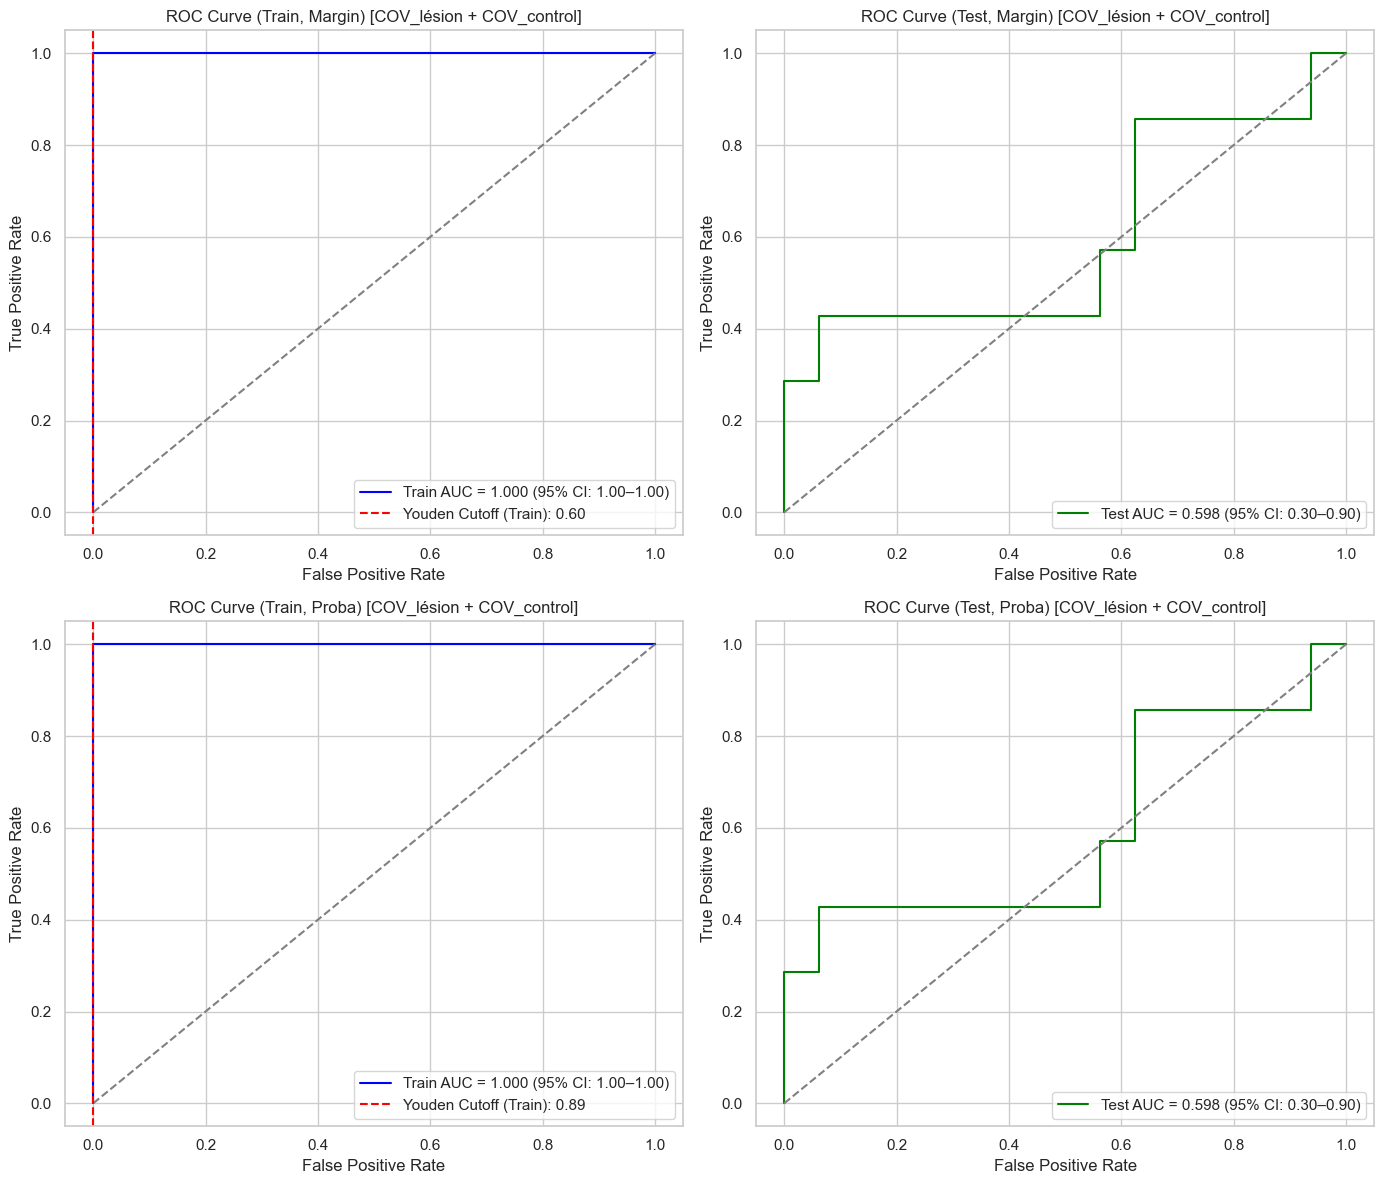

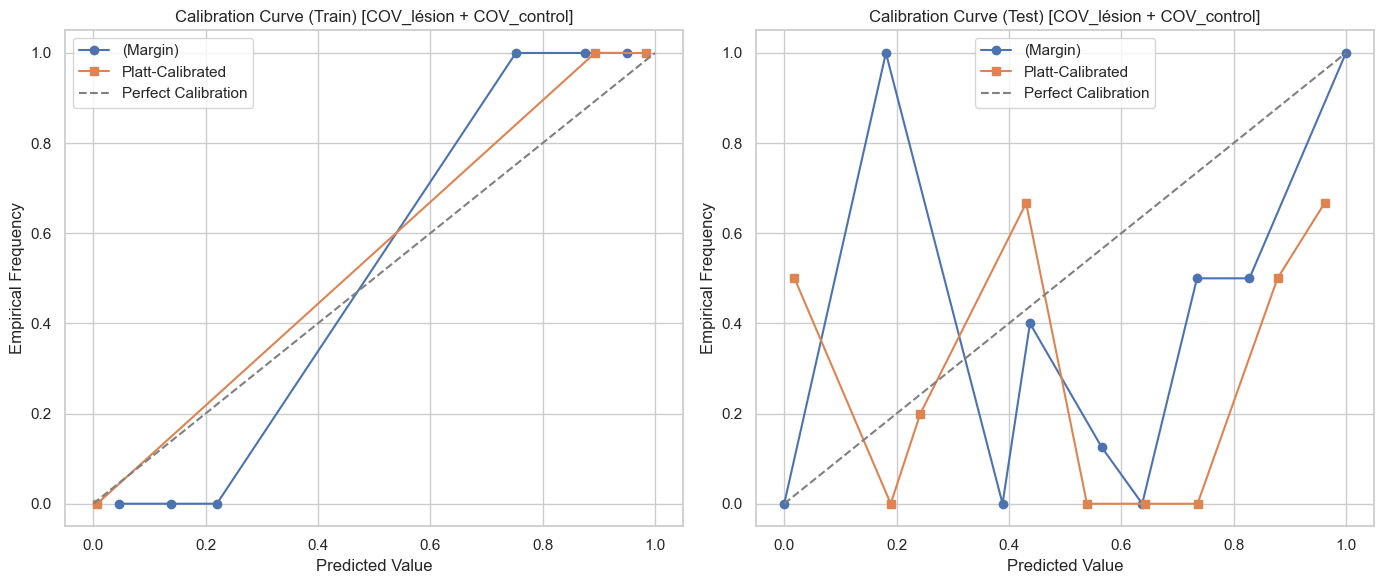

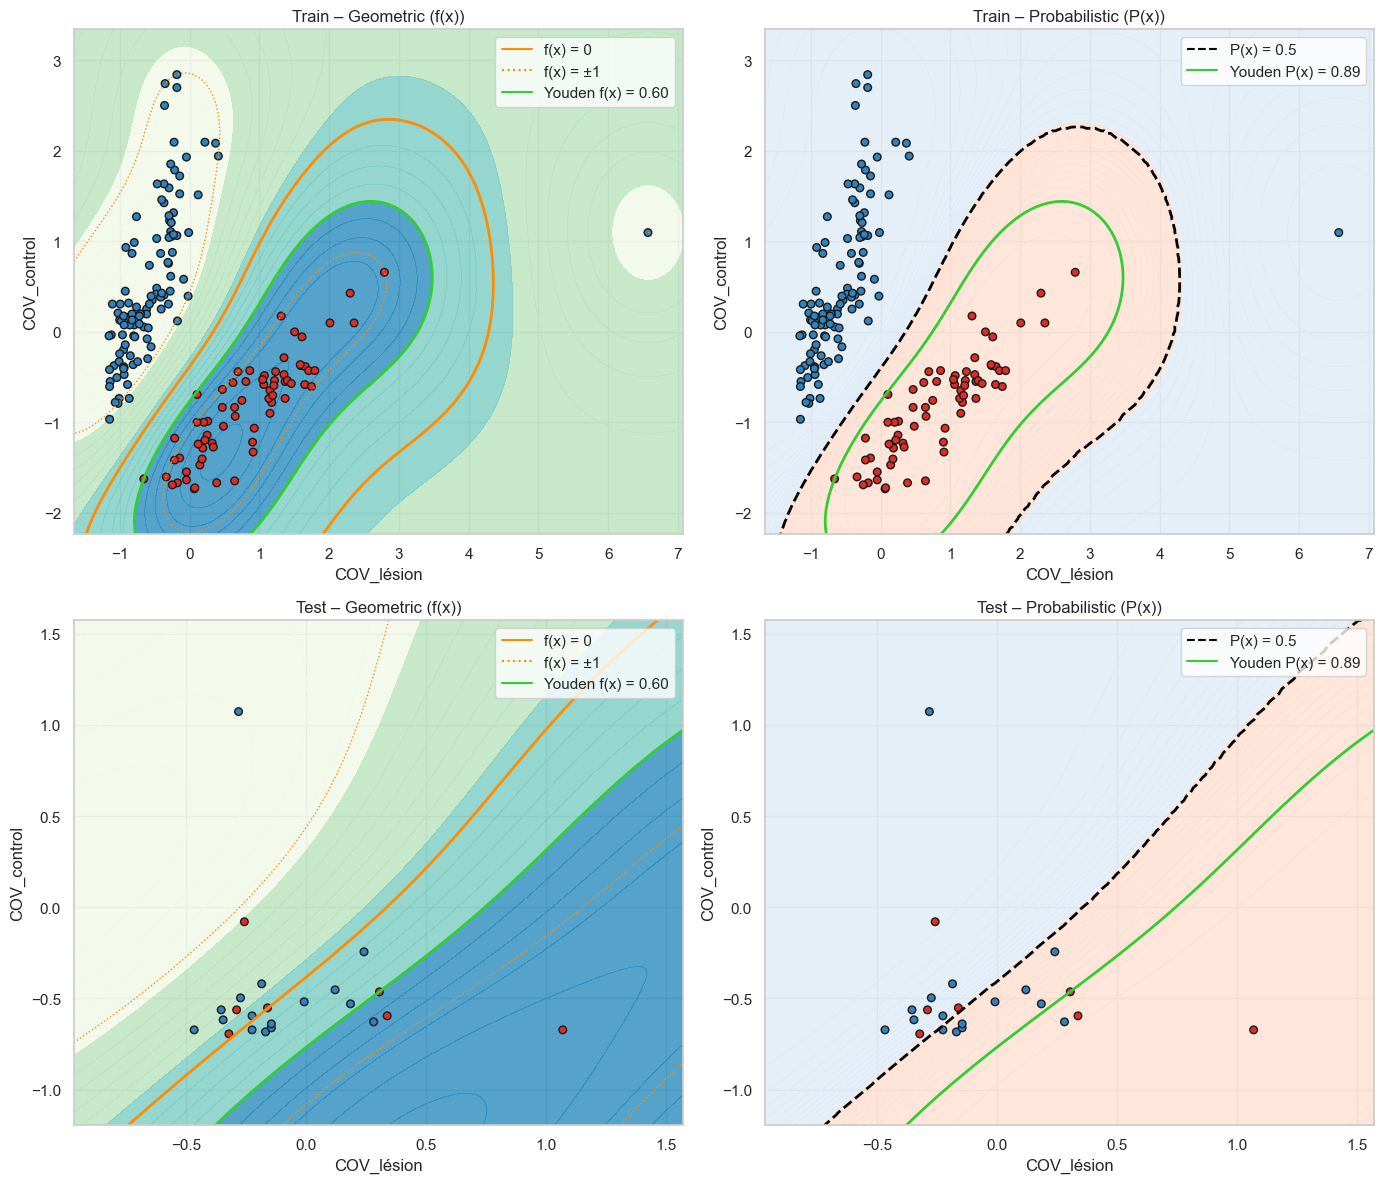

In [23]:
ub.evaluate_svm_bivariate_model(kernel="rbf")

## 6.  Decision Tree Modelling

Covariance of AUC is 0.0; defaulting to a small delta for CI computation.
DECISION TREE (max_depth=3, criterion=GINI): COV_lésion + COV_control + COV_ratio
----------------------------------------------------------------------------------------------------
AUC (Train): 1.000 (95% CI: 1.000 – 1.000)
AUC (Test) : 0.433 (95% CI: 0.199 – 0.667)
----------------------------------------------------------------------------------------------------

▶ [COV_LÉSION + COV_CONTROL + COV_RATIO] TRAIN
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |     100.0
Recall (Sensitivity) |     100.0
Specificity          |     100.0
Precision            |     100.0
F1 Score             |     100.0

▶ [COV_LÉSION + COV_CONTROL + COV_RATIO] TEST
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |  

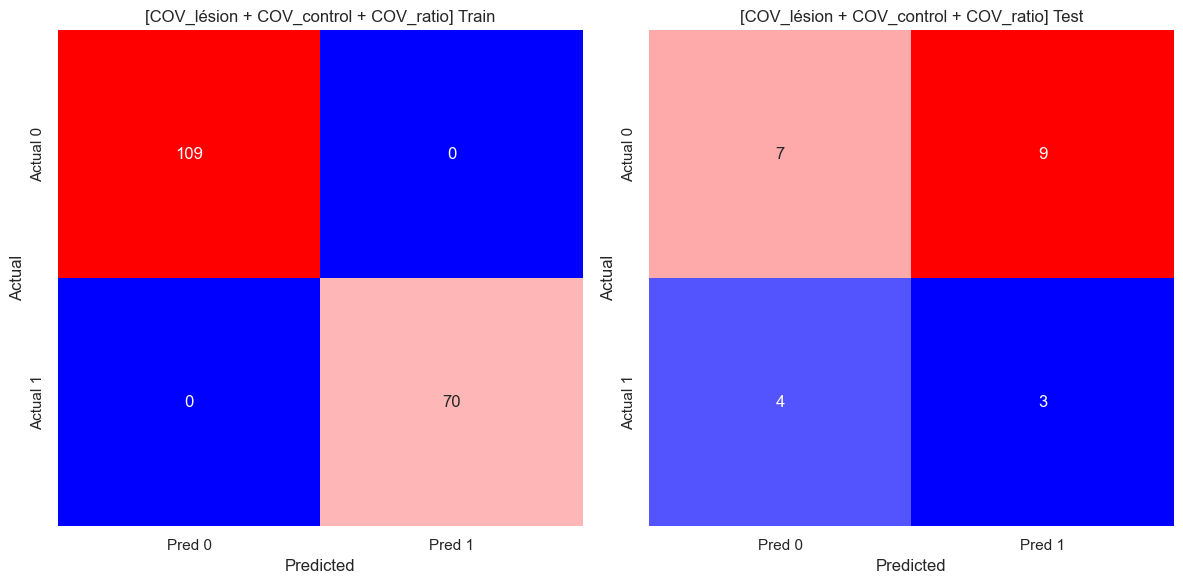

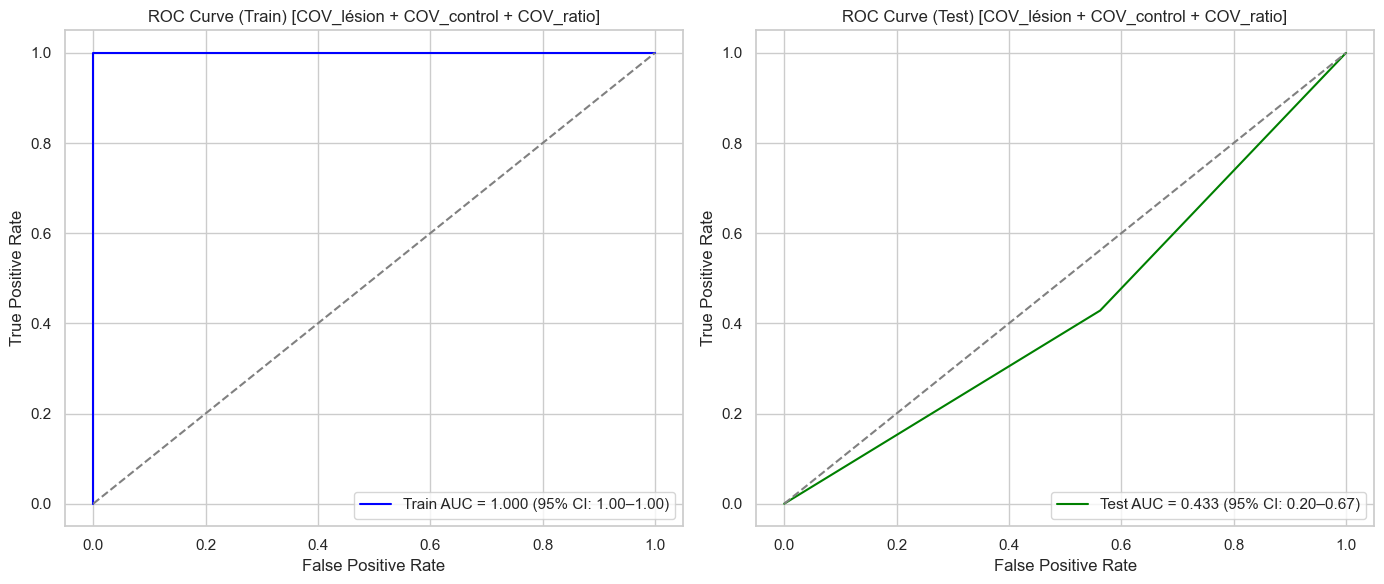

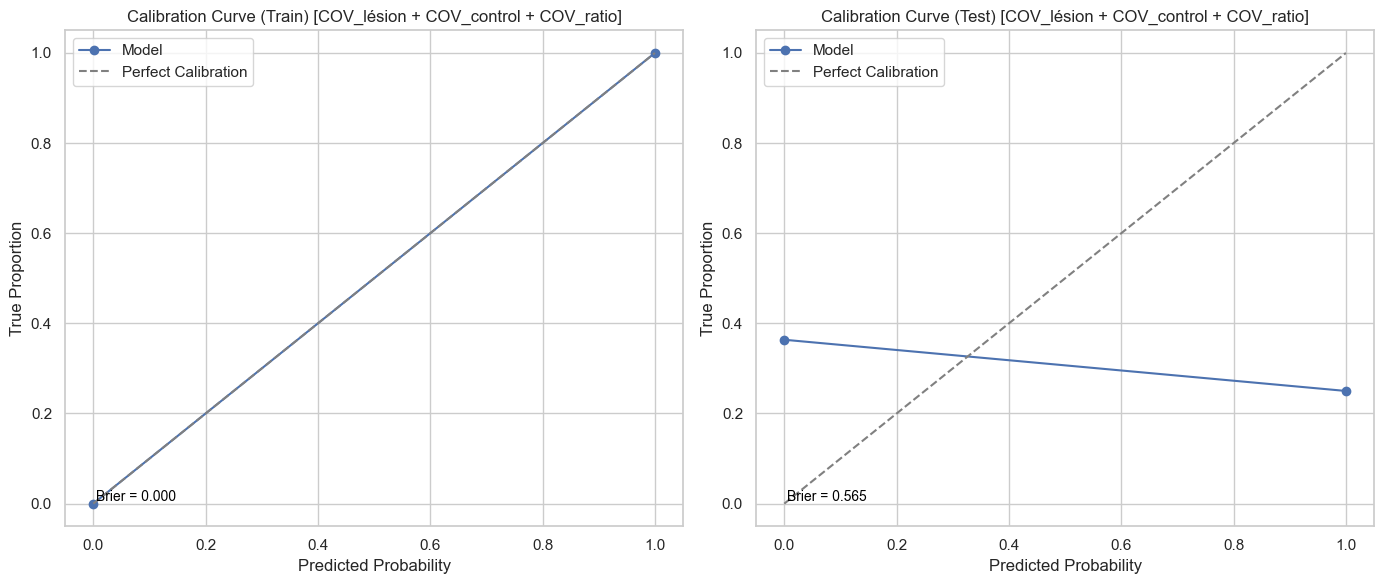

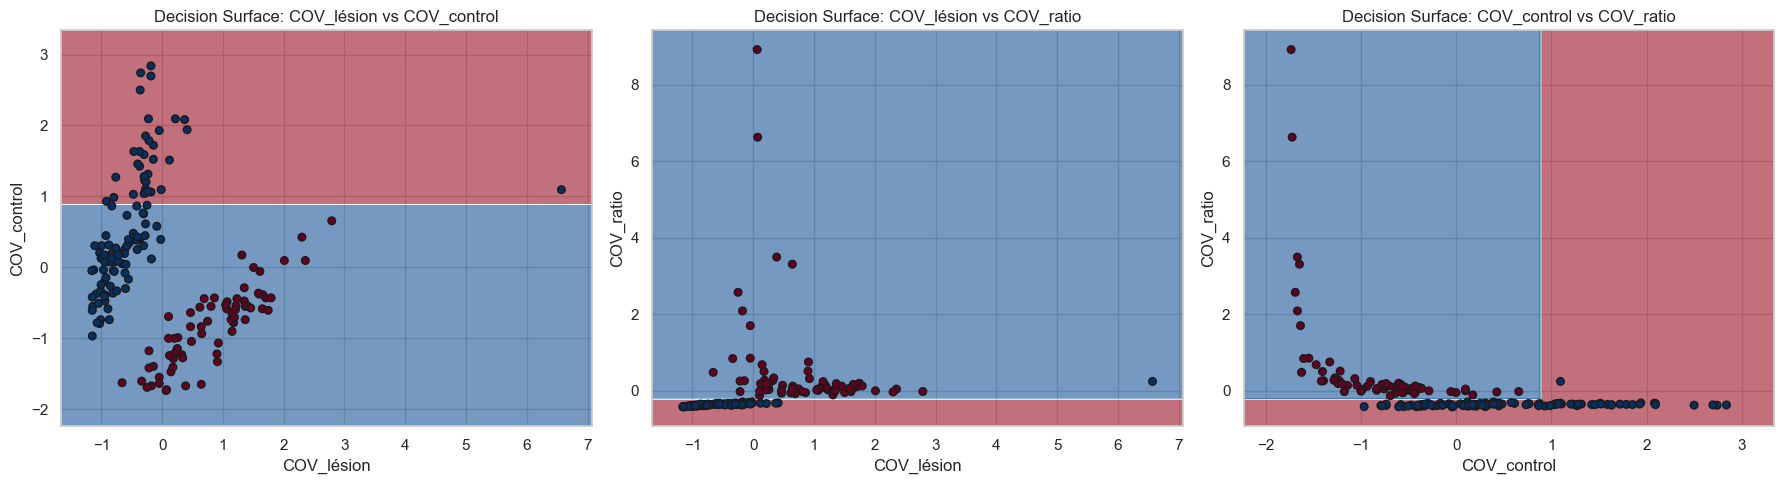

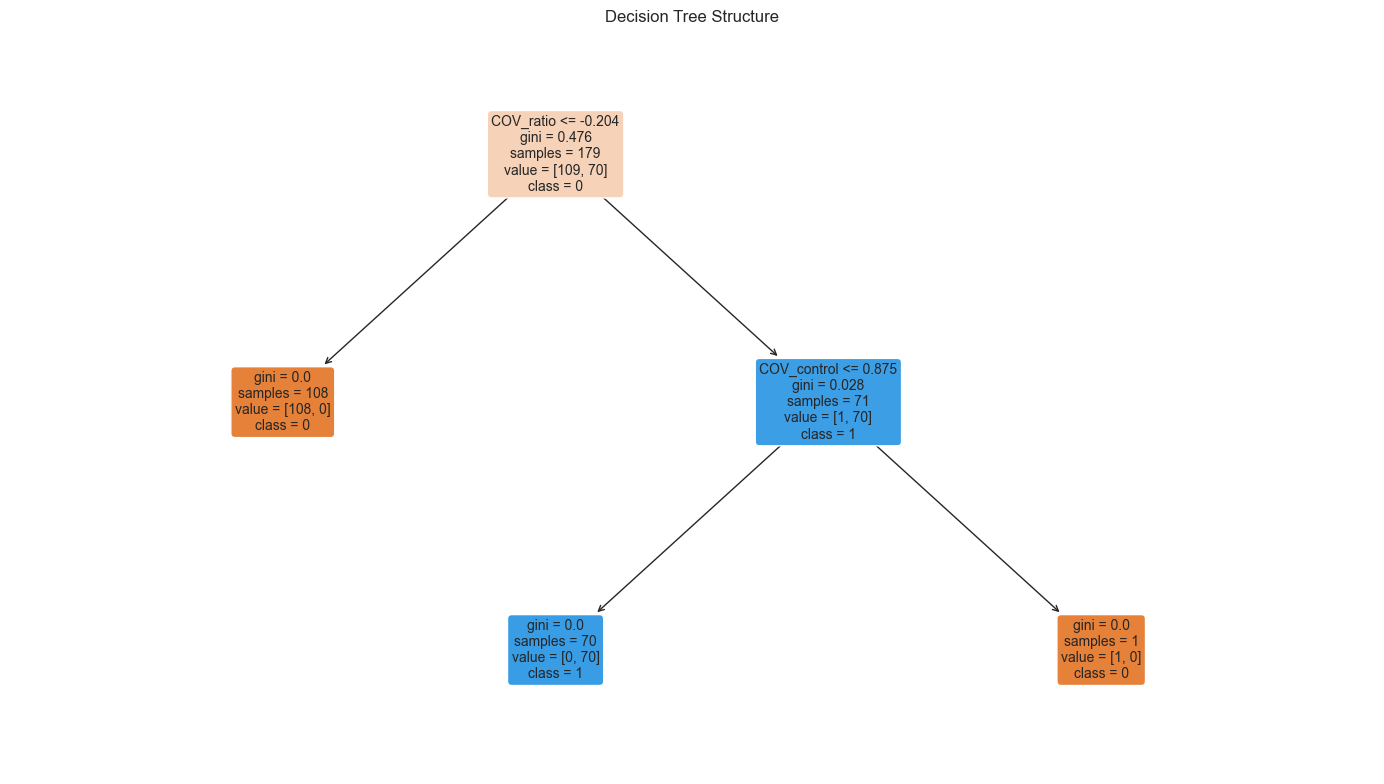


Tree Rules :
--------------------------------------------------------------------------------
|--- COV_ratio <= -0.20
|   |--- class: 0
|--- COV_ratio >  -0.20
|   |--- COV_control <= 0.88
|   |   |--- class: 1
|   |--- COV_control >  0.88
|   |   |--- class: 0



In [24]:
ub.evaluate_tree_trivariate_model()